In [1]:
# импортируем библиотеки numpy, pandas,
# polars, bottleneck
import numpy as np
import pandas as pd
import polars as pl
import bottleneck as bn

# импортируем необходимые классы и функции
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

# импортируем модуль warnings
import warnings

# импортируем модуль pyplot библиотеки matplotlib
import matplotlib.pyplot as plt

# настраиваем визуализацию
%config InlineBackend.figure_format = 'retina'

In [2]:
# загружаем данные
data = pd.read_csv('Data/example.csv', sep='\t')
data

,date,sales
0,09.01.2018,2400
1,10.01.2018,2800
2,11.01.2018,2500
3,12.01.2018,2890
4,13.01.2018,2610
5,14.01.2018,2500
6,15.01.2018,2750
7,16.01.2018,2700
8,17.01.2018,2250
9,18.01.2018,2350


In [3]:
# преобразовываем столбец с датой в тип datetime
data['date'] = pd.to_datetime(data['date'], 
                              format='%d.%m.%Y')
data

,date,sales
0,2018-01-09,2400
1,2018-01-10,2800
2,2018-01-11,2500
3,2018-01-12,2890
4,2018-01-13,2610
5,2018-01-14,2500
6,2018-01-15,2750
7,2018-01-16,2700
8,2018-01-17,2250
9,2018-01-18,2350


In [4]:
# загружаем данные, сразу выполнив парсинг дат
data = pd.read_csv('Data/example.csv', sep='\t',
                   parse_dates=['date'], 
                   date_parser=lambda col: pd.to_datetime(
                       col, format='%d.%m.%Y'))
data

,date,sales
0,2018-01-09,2400
1,2018-01-10,2800
2,2018-01-11,2500
3,2018-01-12,2890
4,2018-01-13,2610
5,2018-01-14,2500
6,2018-01-15,2750
7,2018-01-16,2700
8,2018-01-17,2250
9,2018-01-18,2350


In [5]:
# переводим столбец с датами в UNIX-время
start = pd.Timestamp('1970-01-01')
d = pd.Timedelta('1s')
data['unix'] = (data['date'] - start) // d
data

,date,sales,unix
0,2018-01-09,2400,1515456000
1,2018-01-10,2800,1515542400
2,2018-01-11,2500,1515628800
3,2018-01-12,2890,1515715200
4,2018-01-13,2610,1515801600
5,2018-01-14,2500,1515888000
6,2018-01-15,2750,1515974400
7,2018-01-16,2700,1516060800
8,2018-01-17,2250,1516147200
9,2018-01-18,2350,1516233600


In [6]:
# загружаем данные, сразу прочитав столбец 
# с датами как индекс и выполнив парсинг дат
data = pd.read_csv('Data/example.csv', sep='\t',
                   index_col=['date'],
                   parse_dates=['date'], 
                   date_parser=lambda col: pd.to_datetime(
                       col, format='%d.%m.%Y'))
data

,sales
date,
2018-01-09,2400
2018-01-10,2800
2018-01-11,2500
2018-01-12,2890
2018-01-13,2610
2018-01-14,2500
2018-01-15,2750
2018-01-16,2700
2018-01-17,2250


In [7]:
# удаляем имя индекса
data.index.name = None
data

,sales
2018-01-09,2400
2018-01-10,2800
2018-01-11,2500
2018-01-12,2890
2018-01-13,2610
2018-01-14,2500
2018-01-15,2750
2018-01-16,2700
2018-01-17,2250
2018-01-18,2350


## 1. Лаговые переменные

In [8]:
# создаем лаги

# лаг с запаздыванием на 3 дня
data['Lag3'] = data['sales'].shift(3)
# лаг с запаздыванием на 4 дня
data['Lag4'] = data['sales'].shift(4)
# лаг с запаздыванием на 5 дней
data['Lag5'] = data['sales'].shift(5)
# лаг с запаздыванием на 6 дней
data['Lag6'] = data['sales'].shift(6)
# лаг равен длине набора
data['Lag12'] = data['sales'].shift(12)
# лаг превышает длину набора
data['Lag13'] = data['sales'].shift(13) 
# смотрим результаты
data

,sales,Lag3,Lag4,Lag5,Lag6,Lag12,Lag13
2018-01-09,2400,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-10,2800,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-11,2500,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-12,2890,2400.0,NaN,NaN,NaN,NaN,NaN
2018-01-13,2610,2800.0,2400.0,NaN,NaN,NaN,NaN
2018-01-14,2500,2500.0,2800.0,2400.0,NaN,NaN,NaN
2018-01-15,2750,2890.0,2500.0,2800.0,2400.0,NaN,NaN
2018-01-16,2700,2610.0,2890.0,2500.0,2800.0,NaN,NaN
2018-01-17,2250,2500.0,2610.0,2890.0,2500.0,NaN,NaN
2018-01-18,2350,2750.0,2500.0,2610.0,2890.0,NaN,NaN


In [9]:
# удалим переменные Lag12 и Lag13
data.drop(['Lag12', 'Lag13'], axis=1, inplace=True)
# задаем горизонт
HORIZON = 4
# разбиваем набор на обучающую и тестовую выборки
train, test = data[0:len(data)-HORIZON], data[len(data)-HORIZON:]

In [10]:
# смотрим обучающий набор
train

,sales,Lag3,Lag4,Lag5,Lag6
2018-01-09,2400,NaN,NaN,NaN,NaN
2018-01-10,2800,NaN,NaN,NaN,NaN
2018-01-11,2500,NaN,NaN,NaN,NaN
2018-01-12,2890,2400.0,NaN,NaN,NaN
2018-01-13,2610,2800.0,2400.0,NaN,NaN
2018-01-14,2500,2500.0,2800.0,2400.0,NaN
2018-01-15,2750,2890.0,2500.0,2800.0,2400.0
2018-01-16,2700,2610.0,2890.0,2500.0,2800.0


In [11]:
# смотрим тестовый набор
test

,sales,Lag3,Lag4,Lag5,Lag6
2018-01-17,2250,2500.0,2610.0,2890.0,2500.0
2018-01-18,2350,2750.0,2500.0,2610.0,2890.0
2018-01-19,2550,2700.0,2750.0,2500.0,2610.0
2018-01-20,3000,2250.0,2700.0,2750.0,2500.0


In [12]:
# пишем функцию загрузки
def load_data():
    # загружаем данные, сразу прочитав столбец 
    # с датами как индекс и выполнив парсинг дат
    data = pd.read_csv('Data/example.csv', sep='\t',
                       index_col=['date'],
                       parse_dates=['date'], 
                       date_parser=lambda col: pd.to_datetime(
                           col, format='%d.%m.%Y'))
    # удаляем имя индекса
    data.index.name = None
    return data

In [13]:
# загружаем данные
data = load_data()

# значения в наблюдениях, которые будут приходиться на тест
# (последние 4 наблюдения) заменяем на значения NaN
HORIZON = 4
data['sales'].iloc[-HORIZON:] = np.NaN

# создаем лаги, лаги меньше горизонта прогнозирования
# получат пропуски в наблюдениях, приходящихся на тест,
# при этом чем меньше порядок лага горизонта 
# прогнозирования, тем больше пропусков в тесте

# лаг с запаздыванием на 1 день
data['Lag1'] = data['sales'].shift(1)
# лаг с запаздыванием на 2 дня
data['Lag2'] = data['sales'].shift(2)
# лаг с запаздыванием на 3 дня
data['Lag3'] = data['sales'].shift(3)
# лаг с запаздыванием на 4 дня
data['Lag4'] = data['sales'].shift(4)
# лаг с запаздыванием на 5 дней
data['Lag5'] = data['sales'].shift(5)
data

,sales,Lag1,Lag2,Lag3,Lag4,Lag5
2018-01-09,2400.0,NaN,NaN,NaN,NaN,NaN
2018-01-10,2800.0,2400.0,NaN,NaN,NaN,NaN
2018-01-11,2500.0,2800.0,2400.0,NaN,NaN,NaN
2018-01-12,2890.0,2500.0,2800.0,2400.0,NaN,NaN
2018-01-13,2610.0,2890.0,2500.0,2800.0,2400.0,NaN
2018-01-14,2500.0,2610.0,2890.0,2500.0,2800.0,2400.0
2018-01-15,2750.0,2500.0,2610.0,2890.0,2500.0,2800.0
2018-01-16,2700.0,2750.0,2500.0,2610.0,2890.0,2500.0
2018-01-17,NaN,2700.0,2750.0,2500.0,2610.0,2890.0
2018-01-18,NaN,NaN,2700.0,2750.0,2500.0,2610.0


In [14]:
# удалим лаги по паттерну 'Lag'
data.drop(data.filter(regex='Lag').columns, axis=1, 
          inplace=True)
# создаем обучающую выборку – первые 8 
# наблюдений исходного набора
train = data.iloc[:-HORIZON]
train

,sales
2018-01-09,2400.0
2018-01-10,2800.0
2018-01-11,2500.0
2018-01-12,2890.0
2018-01-13,2610.0
2018-01-14,2500.0
2018-01-15,2750.0
2018-01-16,2700.0


In [15]:
# пишем функцию для создания лагов 
# в обучающей и тестовой выборках
def calculate_lags(train, target, horizon, lags_range, 
                   freq='D', aggregate=False):
    """
    Создает лаги в обучающей и тестовой выборках.
    
    Параметры
    ----------
    train: 
        Обучающий набор.
    target: 
        Название зависимой переменной.
    horizon: 
        Горизонт прогнозирования.
    lags_range: 
        Диапазон значений порядка лагов.
    freq: str, значение по умолчанию 'D'
        Частота временного ряда.
    aggregate: bool, значение по умолчанию False
        Вычисляет агрегированный лаг.
    """
    if min(lags_range) < horizon:
        warnings.warn(f"\nКоличество периодов для лагов нужно задавать\n"
                      f"равным или больше горизонта прогнозирования")
            
    if pd.__version__ >= '1.4':
        # создаем метки времени для горизонта
        future_dates = pd.date_range(start=train.index[-1], 
                                     periods=horizon + 1, 
                                     freq=freq, 
                                     inclusive='right')
    else:
        # создаем метки времени для горизонта
        future_dates = pd.date_range(start=train.index[-1], 
                                     periods=horizon + 1, 
                                     freq=freq, 
                                     closed='right')
    # формируем новый удлиненный индекс
    new_index = train.index.append(future_dates)
    # выполняем переиндексацию
    new_df = train.reindex(new_index)
    # создаем лаги
    for i in lags_range:
        new_df[f"Lag_{i}"] = new_df[target].shift(i)
        
    if aggregate and min(lags_range) >= horizon:
        # вычисляем агрегированный лаг  
        new_df['Agg_Lag'] = new_df[new_df.filter(
            regex='Lag').columns].mean(axis=1)
        
    train = new_df.iloc[:-horizon]
    test = new_df.iloc[-horizon:]
    
    return train, test

In [16]:
# создаем лаги для обучающей и тестовой выборок
tr, tst = calculate_lags(
    train, target='sales', horizon=4, 
    lags_range=range(3, 6), freq='D')

/var/folders/x9/w1kvj6ms0p52l8j6crt19vmh0000gn/T/ipykernel_29664/2041581760.py:24: UserWarning: 
Количество периодов для лагов нужно задавать
равным или больше горизонта прогнозирования
  warnings.warn(f"\nКоличество периодов для лагов нужно задавать\n"


In [17]:
# смотрим лаги в обучающей выборке
tr

,sales,Lag_3,Lag_4,Lag_5
2018-01-09,2400.0,NaN,NaN,NaN
2018-01-10,2800.0,NaN,NaN,NaN
2018-01-11,2500.0,NaN,NaN,NaN
2018-01-12,2890.0,2400.0,NaN,NaN
2018-01-13,2610.0,2800.0,2400.0,NaN
2018-01-14,2500.0,2500.0,2800.0,2400.0
2018-01-15,2750.0,2890.0,2500.0,2800.0
2018-01-16,2700.0,2610.0,2890.0,2500.0


In [18]:
# смотрим лаги в тестовой выборке
tst

,sales,Lag_3,Lag_4,Lag_5
2018-01-17,NaN,2500.0,2610.0,2890.0
2018-01-18,NaN,2750.0,2500.0,2610.0
2018-01-19,NaN,2700.0,2750.0,2500.0
2018-01-20,NaN,NaN,2700.0,2750.0


In [19]:
# создаем лаги и агрегированный лаг
# для обучающей и тестовой выборок
tr, tst = calculate_lags(
    train, target='sales', horizon=4, 
    lags_range=range(4, 6), freq='D', aggregate=True)

In [20]:
# смотрим лаги и агрегированный лаг в обучающей выборке
tr

,sales,Lag_4,Lag_5,Agg_Lag
2018-01-09,2400.0,NaN,NaN,NaN
2018-01-10,2800.0,NaN,NaN,NaN
2018-01-11,2500.0,NaN,NaN,NaN
2018-01-12,2890.0,NaN,NaN,NaN
2018-01-13,2610.0,2400.0,NaN,2400.0
2018-01-14,2500.0,2800.0,2400.0,2600.0
2018-01-15,2750.0,2500.0,2800.0,2650.0
2018-01-16,2700.0,2890.0,2500.0,2695.0


In [21]:
# смотрим лаги и агрегированный лаг в тестовой выборке
tst

,sales,Lag_4,Lag_5,Agg_Lag
2018-01-17,NaN,2610.0,2890.0,2750.0
2018-01-18,NaN,2500.0,2610.0,2555.0
2018-01-19,NaN,2750.0,2500.0,2625.0
2018-01-20,NaN,2700.0,2750.0,2725.0


In [22]:
# пишем функцию, которая вычисляет агрегированный
# лаг на основе взвешенного среднего лагов
def weighted_average_lag(data, lags, lags_weights, 
                         intermediate_results):
    df = data.copy()
    for cnt, i in enumerate(df[lags].columns):
        df[i] = df[i] * lags_weights[cnt]     
    if intermediate_results:
        print(df)
    data['Weighted_Average_Lag'] = df[lags].mean(axis=1)
    return data

In [23]:
%%time

# вычислим агрегированный лаг на основе
# взвешенного среднего лагов
weighted_average_lag(tr, lags=['Lag_4', 'Lag_5'], 
                     lags_weights=[1, 2], 
                     intermediate_results=True)

             sales   Lag_4   Lag_5  Agg_Lag
2018-01-09  2400.0     NaN     NaN      NaN
2018-01-10  2800.0     NaN     NaN      NaN
2018-01-11  2500.0     NaN     NaN      NaN
2018-01-12  2890.0     NaN     NaN      NaN
2018-01-13  2610.0  2400.0     NaN   2400.0
2018-01-14  2500.0  2800.0  4800.0   2600.0
2018-01-15  2750.0  2500.0  5600.0   2650.0
2018-01-16  2700.0  2890.0  5000.0   2695.0
CPU times: user 5.19 ms, sys: 640 µs, total: 5.83 ms
Wall time: 5.32 ms


,sales,Lag_4,Lag_5,Agg_Lag,Weighted_Average_Lag
2018-01-09,2400.0,NaN,NaN,NaN,NaN
2018-01-10,2800.0,NaN,NaN,NaN,NaN
2018-01-11,2500.0,NaN,NaN,NaN,NaN
2018-01-12,2890.0,NaN,NaN,NaN,NaN
2018-01-13,2610.0,2400.0,NaN,2400.0,2400.0
2018-01-14,2500.0,2800.0,2400.0,2600.0,3800.0
2018-01-15,2750.0,2500.0,2800.0,2650.0,4050.0
2018-01-16,2700.0,2890.0,2500.0,2695.0,3945.0


In [24]:
# преобразовываем датафрейм pandas в датафрейм Polars
polars_data = pl.DataFrame(data)
polars_data

sales
f64
2400.0
2800.0
2500.0
2890.0
2610.0
2500.0
2750.0
2700.0
null


In [25]:
# создаем лаги в Polars
polars_data = polars_data.with_columns([
    pl.col('sales').shift(1).alias('Lag_1'),
    pl.col('sales').shift(2).alias('Lag_2'),
    pl.col('sales').shift(3).alias('Lag_3'),
    pl.col('sales').shift(4).alias('Lag_4'),
    pl.col('sales').shift(5).alias('Lag_5')
])
polars_data

sales,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5
f64,f64,f64,f64,f64,f64
2400.0,null,null,null,null,null
2800.0,2400.0,null,null,null,null
2500.0,2800.0,2400.0,null,null,null
2890.0,2500.0,2800.0,2400.0,null,null
2610.0,2890.0,2500.0,2800.0,2400.0,null
2500.0,2610.0,2890.0,2500.0,2800.0,2400.0
2750.0,2500.0,2610.0,2890.0,2500.0,2800.0
2700.0,2750.0,2500.0,2610.0,2890.0,2500.0
null,2700.0,2750.0,2500.0,2610.0,2890.0


In [26]:
# создаем копию
data2 = data.copy()
# на основе индекса создаем переменную с датами
data2['date'] = data2.index
# столбец с датами ставим первым
first_column = data2.pop('date')
data2.insert(0, 'date', first_column)
# преобразовываем датафрейм pandas в датафрейм Polars
polars_data = pl.DataFrame(data2)
# присваиваем столбцу с датами тип Date
polars_data = polars_data.with_column(
    pl.col('date').cast(pl.Date))
polars_data

date,sales
date,f64
2018-01-09,2400.0
2018-01-10,2800.0
2018-01-11,2500.0
2018-01-12,2890.0
2018-01-13,2610.0
2018-01-14,2500.0
2018-01-15,2750.0
2018-01-16,2700.0
2018-01-17,null


In [27]:
# создаем список лагов
lags_lst = list(range(1, 6))
# создаем лаги в Polars
for i in lags_lst:
    polars_data = polars_data.with_columns([
        pl.col('sales').shift(i).alias(f"Lag_{i}")
    ])
polars_data

date,sales,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5
date,f64,f64,f64,f64,f64,f64
2018-01-09,2400.0,null,null,null,null,null
2018-01-10,2800.0,2400.0,null,null,null,null
2018-01-11,2500.0,2800.0,2400.0,null,null,null
2018-01-12,2890.0,2500.0,2800.0,2400.0,null,null
2018-01-13,2610.0,2890.0,2500.0,2800.0,2400.0,null
2018-01-14,2500.0,2610.0,2890.0,2500.0,2800.0,2400.0
2018-01-15,2750.0,2500.0,2610.0,2890.0,2500.0,2800.0
2018-01-16,2700.0,2750.0,2500.0,2610.0,2890.0,2500.0
2018-01-17,null,2700.0,2750.0,2500.0,2610.0,2890.0


In [28]:
# создаем копию
train2 = train.copy()
# на основе индекса создаем переменную с датами
train2['date'] = train2.index
# столбец с датами ставим первым
first_column = train2.pop('date')
train2.insert(0, 'date', first_column)
# преобразовываем датафрейм pandas в датафрейм Polars
polars_train_data = pl.DataFrame(train2)
# присваиваем столбцу с датами тип Date
polars_train_data = polars_train_data.with_column(
    pl.col('date').cast(pl.Date))
polars_train_data

date,sales
date,f64
2018-01-09,2400.0
2018-01-10,2800.0
2018-01-11,2500.0
2018-01-12,2890.0
2018-01-13,2610.0
2018-01-14,2500.0
2018-01-15,2750.0
2018-01-16,2700.0


In [29]:
# пишем функцию для создания лагов 
# в обучающей и тестовой выборках
def polars_calculate_lags(polars_train, target_column, date_column, 
                          horizon, lags_range, aggregate=False):
    """
    Создает лаги в обучающей и тестовой выборках.
    
    Параметры
    ----------
    train: 
        Обучающий набор.
    target_column: 
        Название зависимой переменной.
    date_column:
        Название переменной c датами.
    horizon: 
        Горизонт прогнозирования.
    lags_range: 
        Диапазон значений порядка лагов.
    aggregate: bool, значение по умолчанию False
        Вычисляет агрегированный лаг.
    """
    # вычисляем длину горизонта
    h = len(horizon)
    
    if min(lags_range) < h:
        warnings.warn(f"\nКоличество периодов для лагов нужно задавать\n"
                      f"равным или больше горизонта прогнозирования")
    
    # удлиняем набор на длину горизонта
    dates = polars_train.select(date_column).to_series()
    steps = pl.Series(date_column, horizon).str.strptime(
        pl.Date, fmt='%Y-%m-%d')
    final_dates = dates.append(steps).to_frame()
    polars_df = polars_train.join(final_dates, how='outer', on=date_column)
   
    # создаем лаги в Polars
    for i in lags_range:
        polars_df = polars_df.with_columns([
            pl.col(target_column).shift(i).alias(f"Lag_{i}")
        ])    
        
    if aggregate and min(lags_range) >= h:
        # вычисляем агрегированный лаг
        polars_df = polars_df.with_columns([polars_df.select(
            pl.col('^Lag_.*$')).mean(axis=1).alias('Agg_Lag')])
        
    train = polars_df[0:len(final_dates) - h]
    test = polars_df[len(final_dates) - h:]
    
    return train, test

In [30]:
# создаем лаги для обучающей и тестовой выборок
polars_train, polars_test = polars_calculate_lags(
    polars_train_data, 'sales', 'date', 
    horizon=['2018-01-17', '2018-01-18', 
             '2018-01-19', '2018-01-20'],
    lags_range=range(3, 6))

/var/folders/x9/w1kvj6ms0p52l8j6crt19vmh0000gn/T/ipykernel_29664/3589521078.py:27: UserWarning: 
Количество периодов для лагов нужно задавать
равным или больше горизонта прогнозирования
  warnings.warn(f"\nКоличество периодов для лагов нужно задавать\n"


In [31]:
# смотрим лаги в обучающей выборке
polars_train

date,sales,Lag_3,Lag_4,Lag_5
date,f64,f64,f64,f64
2018-01-09,2400.0,null,null,null
2018-01-10,2800.0,null,null,null
2018-01-11,2500.0,null,null,null
2018-01-12,2890.0,2400.0,null,null
2018-01-13,2610.0,2800.0,2400.0,null
2018-01-14,2500.0,2500.0,2800.0,2400.0
2018-01-15,2750.0,2890.0,2500.0,2800.0
2018-01-16,2700.0,2610.0,2890.0,2500.0


In [32]:
# смотрим лаги в тестовой выборке
polars_test

date,sales,Lag_3,Lag_4,Lag_5
date,f64,f64,f64,f64
2018-01-17,null,2500.0,2610.0,2890.0
2018-01-18,null,2750.0,2500.0,2610.0
2018-01-19,null,2700.0,2750.0,2500.0
2018-01-20,null,null,2700.0,2750.0


In [33]:
# создаем лаги и агрегированный лаг
# для обучающей и тестовой выборок
polars_train, polars_test = polars_calculate_lags(
    polars_train_data, 'sales', 'date', 
    horizon=['2018-01-17', '2018-01-18', 
             '2018-01-19', '2018-01-20'],
    lags_range=range(4, 6),
    aggregate=True)

In [34]:
# смотрим лаги и агрегированный лаг в обучающей выборке
polars_train

date,sales,Lag_4,Lag_5,Agg_Lag
date,f64,f64,f64,f64
2018-01-09,2400.0,null,null,null
2018-01-10,2800.0,null,null,null
2018-01-11,2500.0,null,null,null
2018-01-12,2890.0,null,null,null
2018-01-13,2610.0,2400.0,null,2400.0
2018-01-14,2500.0,2800.0,2400.0,2600.0
2018-01-15,2750.0,2500.0,2800.0,2650.0
2018-01-16,2700.0,2890.0,2500.0,2695.0


In [35]:
# смотрим лаги и агрегированный лаг в тестовой выборке
polars_test

date,sales,Lag_4,Lag_5,Agg_Lag
date,f64,f64,f64,f64
2018-01-17,null,2610.0,2890.0,2750.0
2018-01-18,null,2500.0,2610.0,2555.0
2018-01-19,null,2750.0,2500.0,2625.0
2018-01-20,null,2700.0,2750.0,2725.0


## 2. Разности

In [36]:
# создаем лаги
data['Lag3'] = data['sales'].shift(3)
data['Lag4'] = data['sales'].shift(4)
data['Lag5'] = data['sales'].shift(5)

# создаем разности на основе лагов
data['Diff_on_Lag3'] = data['Lag3'].diff()
data['Diff_on_Lag4'] = data['Lag4'].diff()
data['Diff_on_Lag5'] = data['Lag5'].diff()
data['Diff2_on_Lag4'] = data['Lag4'].diff(2)
data['Diff2_on_Lag5'] = data['Lag5'].diff(2)
data

,sales,Lag3,Lag4,Lag5,Diff_on_Lag3,Diff_on_Lag4,Diff_on_Lag5,Diff2_on_Lag4,Diff2_on_Lag5
2018-01-09,2400.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-10,2800.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-11,2500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-12,2890.0,2400.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-13,2610.0,2800.0,2400.0,NaN,400.0,NaN,NaN,NaN,NaN
2018-01-14,2500.0,2500.0,2800.0,2400.0,-300.0,400.0,NaN,NaN,NaN
2018-01-15,2750.0,2890.0,2500.0,2800.0,390.0,-300.0,400.0,100.0,NaN
2018-01-16,2700.0,2610.0,2890.0,2500.0,-280.0,390.0,-300.0,90.0,100.0
2018-01-17,NaN,2500.0,2610.0,2890.0,-110.0,-280.0,390.0,110.0,90.0
2018-01-18,NaN,2750.0,2500.0,2610.0,250.0,-110.0,-280.0,-390.0,110.0


In [37]:
# разбиваем набор на обучающую и тестовую выборки
train, test = data[0:len(data)-HORIZON], data[len(data)-HORIZON:]

In [38]:
# смотрим обучающий набор
train

,sales,Lag3,Lag4,Lag5,Diff_on_Lag3,Diff_on_Lag4,Diff_on_Lag5,Diff2_on_Lag4,Diff2_on_Lag5
2018-01-09,2400.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-10,2800.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-11,2500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-12,2890.0,2400.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-13,2610.0,2800.0,2400.0,NaN,400.0,NaN,NaN,NaN,NaN
2018-01-14,2500.0,2500.0,2800.0,2400.0,-300.0,400.0,NaN,NaN,NaN
2018-01-15,2750.0,2890.0,2500.0,2800.0,390.0,-300.0,400.0,100.0,NaN
2018-01-16,2700.0,2610.0,2890.0,2500.0,-280.0,390.0,-300.0,90.0,100.0


In [39]:
# смотрим тестовый набор
test

,sales,Lag3,Lag4,Lag5,Diff_on_Lag3,Diff_on_Lag4,Diff_on_Lag5,Diff2_on_Lag4,Diff2_on_Lag5
2018-01-17,NaN,2500.0,2610.0,2890.0,-110.0,-280.0,390.0,110.0,90.0
2018-01-18,NaN,2750.0,2500.0,2610.0,250.0,-110.0,-280.0,-390.0,110.0
2018-01-19,NaN,2700.0,2750.0,2500.0,-50.0,250.0,-110.0,140.0,-390.0
2018-01-20,NaN,NaN,2700.0,2750.0,NaN,-50.0,250.0,200.0,140.0


In [40]:
# удаляем лаги 1, 2, 3
polars_data = polars_data.drop(['Lag_1', 'Lag_2', 'Lag_3'])
# создаем разности в Polars
polars_data = polars_data.with_columns([
    pl.col('Lag_4').diff(1).alias('Diff_on_Lag4'),
    pl.col('Lag_5').diff(1).alias('Diff_on_Lag5'),
    pl.col('Lag_4').diff(2).alias('Diff2_on_Lag4'),
    pl.col('Lag_5').diff(2).alias('Diff2_on_Lag5')
    ])
polars_data

date,sales,Lag_4,Lag_5,Diff_on_Lag4,Diff_on_Lag5,Diff2_on_Lag4,Diff2_on_Lag5
date,f64,f64,f64,f64,f64,f64,f64
2018-01-09,2400.0,null,null,null,null,null,null
2018-01-10,2800.0,null,null,null,null,null,null
2018-01-11,2500.0,null,null,null,null,null,null
2018-01-12,2890.0,null,null,null,null,null,null
2018-01-13,2610.0,2400.0,null,null,null,null,null
2018-01-14,2500.0,2800.0,2400.0,400.0,null,null,null
2018-01-15,2750.0,2500.0,2800.0,-300.0,400.0,100.0,null
2018-01-16,2700.0,2890.0,2500.0,390.0,-300.0,90.0,100.0
2018-01-17,null,2610.0,2890.0,-280.0,390.0,110.0,90.0


## 3. Скользящие статистики

In [41]:
# загружаем данные
data = load_data()

# создаем скользящие средние с размерами окна 3, 12 и 13
data['rolling_mean3'] = data['sales'].rolling(window=3).mean()
data['rolling_mean12'] = data['sales'].rolling(window=12).mean()
data['rolling_mean13'] = data['sales'].rolling(window=13).mean()
data

,sales,rolling_mean3,rolling_mean12,rolling_mean13
2018-01-09,2400,NaN,NaN,NaN
2018-01-10,2800,NaN,NaN,NaN
2018-01-11,2500,2566.666667,NaN,NaN
2018-01-12,2890,2730.000000,NaN,NaN
2018-01-13,2610,2666.666667,NaN,NaN
2018-01-14,2500,2666.666667,NaN,NaN
2018-01-15,2750,2620.000000,NaN,NaN
2018-01-16,2700,2650.000000,NaN,NaN
2018-01-17,2250,2566.666667,NaN,NaN
2018-01-18,2350,2433.333333,NaN,NaN


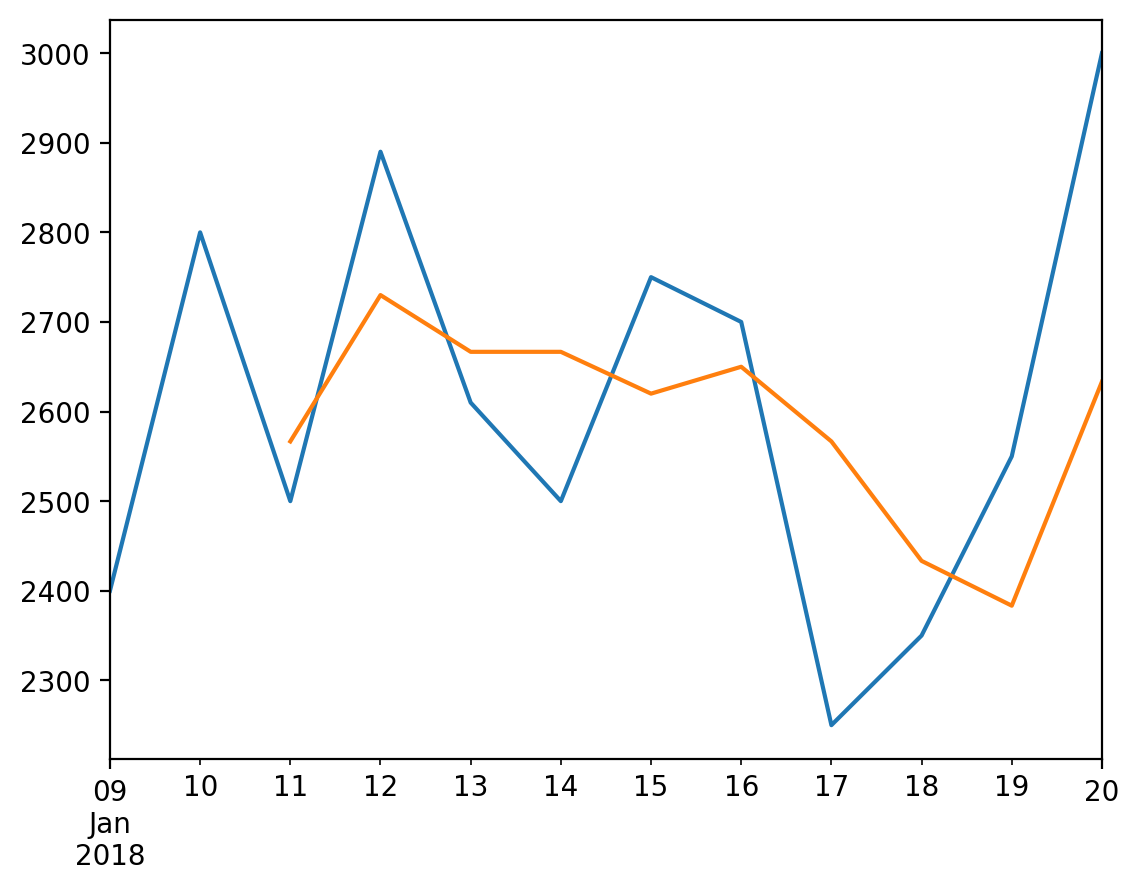

In [42]:
# визуализируем скользящие средние с шириной окна 3
data['sales'].plot()
data['rolling_mean3'].plot();

In [43]:
# создаем скользящие средние, окно шириной 3 и минимальным
# количеством наблюдений в окне, равным 2
data['rolling_mean3_min_periods_2'] = data['sales'].rolling(
    window=3, min_periods=2).mean()
data

,sales,rolling_mean3,rolling_mean12,rolling_mean13,rolling_mean3_min_periods_2
2018-01-09,2400,NaN,NaN,NaN,NaN
2018-01-10,2800,NaN,NaN,NaN,2600.000000
2018-01-11,2500,2566.666667,NaN,NaN,2566.666667
2018-01-12,2890,2730.000000,NaN,NaN,2730.000000
2018-01-13,2610,2666.666667,NaN,NaN,2666.666667
2018-01-14,2500,2666.666667,NaN,NaN,2666.666667
2018-01-15,2750,2620.000000,NaN,NaN,2620.000000
2018-01-16,2700,2650.000000,NaN,NaN,2650.000000
2018-01-17,2250,2566.666667,NaN,NaN,2566.666667
2018-01-18,2350,2433.333333,NaN,NaN,2433.333333


In [44]:
# удалим переменные по паттерну 'rolling_mean'
data.drop(data.filter(regex='rolling_mean').columns, 
          axis=1, inplace=True)

# вычисляем скользящие средние с шириной 3 и 4
# и с лагом 3, 4, 5 и min_periods 1
data['rolling_mean3_lag3'] = data['sales'].shift(periods=3).rolling(
    min_periods=1, window=3).mean()
data['rolling_mean4_lag3'] = data['sales'].shift(periods=3).rolling(
    min_periods=1, window=4).mean()
data['rolling_mean3_lag4'] = data['sales'].shift(periods=4).rolling(
    min_periods=1, window=3).mean()
data['rolling_mean4_lag4'] = data['sales'].shift(periods=4).rolling(
    min_periods=1, window=4).mean()
data['rolling_mean3_lag5'] = data['sales'].shift(periods=5).rolling(
    min_periods=1, window=3).mean()
data['rolling_mean4_lag5'] = data['sales'].shift(periods=5).rolling(
    min_periods=1, window=4).mean()
data

,sales,rolling_mean3_lag3,rolling_mean4_lag3,rolling_mean3_lag4,rolling_mean4_lag4,rolling_mean3_lag5,rolling_mean4_lag5
2018-01-09,2400,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-10,2800,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-11,2500,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-12,2890,2400.000000,2400.000000,NaN,NaN,NaN,NaN
2018-01-13,2610,2600.000000,2600.000000,2400.000000,2400.000000,NaN,NaN
2018-01-14,2500,2566.666667,2566.666667,2600.000000,2600.000000,2400.000000,2400.000000
2018-01-15,2750,2730.000000,2647.500000,2566.666667,2566.666667,2600.000000,2600.000000
2018-01-16,2700,2666.666667,2700.000000,2730.000000,2647.500000,2566.666667,2566.666667
2018-01-17,2250,2666.666667,2625.000000,2666.666667,2700.000000,2730.000000,2647.500000
2018-01-18,2350,2620.000000,2687.500000,2666.666667,2625.000000,2666.666667,2700.000000


In [45]:
# вычисление rolling_mean3_lag3
print(np.nan)
print(np.nan)
print(np.nan)
print(2400 / 1)
print((2400 + 2800) / 2)
print((2400 + 2800 + 2500) / 3)
print((2800 + 2500 + 2890) / 3)
print((2500 + 2890 + 2610) / 3)
print((2890 + 2610 + 2500) / 3)
print((2610 + 2500 + 2750) / 3)
print((2500 + 2750 + 2700) / 3)
print((2750 + 2700 + 2250) / 3)

nan
nan
nan
2400.0
2600.0
2566.6666666666665
2730.0
2666.6666666666665
2666.6666666666665
2620.0
2650.0
2566.6666666666665


In [46]:
# вычисление rolling_mean4_lag3
print(np.nan)
print(np.nan)
print(np.nan)
print(2400 / 1)
print((2400 + 2800) / 2)
print((2400 + 2800 + 2500) / 3)
print((2400 + 2800 + 2500 + 2890) / 4)
print((2800 + 2500 + 2890 + 2610) / 4)
print((2500 + 2890 + 2610 + 2500) / 4)
print((2890 + 2610 + 2500 + 2750) / 4)
print((2610 + 2500 + 2750 + 2700) / 4)
print((2500 + 2750 + 2700 + 2250) / 4)

nan
nan
nan
2400.0
2600.0
2566.6666666666665
2647.5
2700.0
2625.0
2687.5
2640.0
2550.0


In [47]:
# вычисление rolling_mean3_lag4
print(np.nan)
print(np.nan)
print(np.nan)
print(np.nan)
print(2400 / 1)
print((2400 + 2800) / 2)
print((2400 + 2800 + 2500) / 3)
print((2800 + 2500 + 2890) / 3)
print((2500 + 2890 + 2610) / 3)
print((2890 + 2610 + 2500) / 3)
print((2610 + 2500 + 2750) / 3)
print((2500 + 2750 + 2700) / 3)

nan
nan
nan
nan
2400.0
2600.0
2566.6666666666665
2730.0
2666.6666666666665
2666.6666666666665
2620.0
2650.0


In [48]:
# вычисление rolling_mean4_lag4
print(np.nan)
print(np.nan)
print(np.nan)
print(np.nan)
print(2400 / 1)
print((2400 + 2800) / 2)
print((2400 + 2800 + 2500) / 3)
print((2400 + 2800 + 2500 + 2890) / 4)
print((2800 + 2500 + 2890 + 2610) / 4)
print((2500 + 2890 + 2610 + 2500) / 4)
print((2890 + 2610 + 2500 + 2750) / 4)
print((2610 + 2500 + 2750 + 2700) / 4)

nan
nan
nan
nan
2400.0
2600.0
2566.6666666666665
2647.5
2700.0
2625.0
2687.5
2640.0


In [49]:
# вычисляем скользящие средние с шириной 3 и 4
# и с лагом 3, 4, 5 с min_periods по умолчанию
data['rolling_mean3_lag3'] = data['sales'].shift(periods=3).rolling(
    window=3).mean()
data['rolling_mean4_lag3'] = data['sales'].shift(periods=3).rolling(
    window=4).mean()
data['rolling_mean3_lag4'] = data['sales'].shift(periods=4).rolling(
    window=3).mean()
data['rolling_mean4_lag4'] = data['sales'].shift(periods=4).rolling(
    window=4).mean()
data['rolling_mean3_lag5'] = data['sales'].shift(periods=5).rolling(
    window=3).mean()
data['rolling_mean4_lag5'] = data['sales'].shift(periods=5).rolling(
    window=4).mean()
data

,sales,rolling_mean3_lag3,rolling_mean4_lag3,rolling_mean3_lag4,rolling_mean4_lag4,rolling_mean3_lag5,rolling_mean4_lag5
2018-01-09,2400,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-10,2800,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-11,2500,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-12,2890,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-13,2610,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-14,2500,2566.666667,NaN,NaN,NaN,NaN,NaN
2018-01-15,2750,2730.000000,2647.5,2566.666667,NaN,NaN,NaN
2018-01-16,2700,2666.666667,2700.0,2730.000000,2647.5,2566.666667,NaN
2018-01-17,2250,2666.666667,2625.0,2666.666667,2700.0,2730.000000,2647.5
2018-01-18,2350,2620.000000,2687.5,2666.666667,2625.0,2666.666667,2700.0


In [50]:
# удалим переменные по паттерну 'rolling_mean'
data.drop(data.filter(regex='rolling_mean').columns, 
          axis=1, inplace=True)
# значения в наблюдениях, которые будут приходиться на тест
# (последние 4 наблюдения), заменяем на значения NaN
data['sales'].iloc[-HORIZON:] = np.NaN
data

,sales
2018-01-09,2400.0
2018-01-10,2800.0
2018-01-11,2500.0
2018-01-12,2890.0
2018-01-13,2610.0
2018-01-14,2500.0
2018-01-15,2750.0
2018-01-16,2700.0
2018-01-17,NaN
2018-01-18,NaN


In [51]:
# вычисляем скользящее среднее с шириной окна 4 и лагом 1
data['rolling_mean4_lag1'] = data['sales'].shift(
    periods=1).rolling(window=4, min_periods=1).mean()
data

,sales,rolling_mean4_lag1
2018-01-09,2400.0,NaN
2018-01-10,2800.0,2400.000000
2018-01-11,2500.0,2600.000000
2018-01-12,2890.0,2566.666667
2018-01-13,2610.0,2647.500000
2018-01-14,2500.0,2700.000000
2018-01-15,2750.0,2625.000000
2018-01-16,2700.0,2687.500000
2018-01-17,NaN,2640.000000
2018-01-18,NaN,2650.000000


In [52]:
# вычисление rolling_mean4_lag1
print(np.nan)
print(2400 / 1)
print((2400 + 2800) / 2)
print((2400 + 2800 + 2500) / 3)
print((2400 + 2800 + 2500 + 2890) / 4)
print((2800 + 2500 + 2890 + 2610) / 4)
print((2500 + 2890 + 2610 + 2500) / 4)
print((2890 + 2610 + 2500 + 2750) / 4)
print((2610 + 2500 + 2750 + 2700) / 4)
print((2500 + 2750 + 2700) / 3)
print((2750 + 2700) / 2)
print(2700 / 1)

nan
2400.0
2600.0
2566.6666666666665
2647.5
2700.0
2625.0
2687.5
2640.0
2650.0
2725.0
2700.0


In [53]:
# вычисляем скользящее среднее с шириной окна 4 без лага
data['rolling_mean4'] = data['sales'].rolling(
    window=4, min_periods=1).mean()
data

,sales,rolling_mean4_lag1,rolling_mean4
2018-01-09,2400.0,NaN,2400.000000
2018-01-10,2800.0,2400.000000,2600.000000
2018-01-11,2500.0,2600.000000,2566.666667
2018-01-12,2890.0,2566.666667,2647.500000
2018-01-13,2610.0,2647.500000,2700.000000
2018-01-14,2500.0,2700.000000,2625.000000
2018-01-15,2750.0,2625.000000,2687.500000
2018-01-16,2700.0,2687.500000,2640.000000
2018-01-17,NaN,2640.000000,2650.000000
2018-01-18,NaN,2650.000000,2725.000000


In [54]:
# вычисляем скользящие средние с шириной окна 
# 5 без лага и с лагом
data['rolling_mean5'] = data['sales'].rolling(
    window=5, min_periods=1).mean()
data['rolling_mean5_lag1'] = data['sales'].shift(1).rolling(
    window=5, min_periods=1).mean()
data

,sales,rolling_mean4_lag1,rolling_mean4,rolling_mean5,rolling_mean5_lag1
2018-01-09,2400.0,NaN,2400.000000,2400.000000,NaN
2018-01-10,2800.0,2400.000000,2600.000000,2600.000000,2400.000000
2018-01-11,2500.0,2600.000000,2566.666667,2566.666667,2600.000000
2018-01-12,2890.0,2566.666667,2647.500000,2647.500000,2566.666667
2018-01-13,2610.0,2647.500000,2700.000000,2640.000000,2647.500000
2018-01-14,2500.0,2700.000000,2625.000000,2660.000000,2640.000000
2018-01-15,2750.0,2625.000000,2687.500000,2650.000000,2660.000000
2018-01-16,2700.0,2687.500000,2640.000000,2690.000000,2650.000000
2018-01-17,NaN,2640.000000,2650.000000,2640.000000,2690.000000
2018-01-18,NaN,2650.000000,2725.000000,2650.000000,2640.000000


In [55]:
# пишем функцию, которая вычисляет агрегированные скользящие
# статистики на основе усреднения - обычного и с весами
def average_moving_stats(data, moving_stats, moving_stats_weights, 
                         intermediate_results, out_column):
    df = data.copy()
    for cnt, i in enumerate(df[moving_stats].columns):
        df[i] = df[i] * moving_stats_weights[cnt]     
    if intermediate_results:
        print(df)   
    data[f"{out_column}"] = df[moving_stats].mean(axis=1)
    return data

In [56]:
# вычисляем обычное среднее скользящих средних
data = average_moving_stats(
    data=data, 
    moving_stats=['rolling_mean4', 'rolling_mean5'],
                            moving_stats_weights=[1, 1], 
                            intermediate_results=False,
                            out_column='averaged_moving_mean')
data

,sales,rolling_mean4_lag1,rolling_mean4,rolling_mean5,rolling_mean5_lag1,averaged_moving_mean
2018-01-09,2400.0,NaN,2400.000000,2400.000000,NaN,2400.000000
2018-01-10,2800.0,2400.000000,2600.000000,2600.000000,2400.000000,2600.000000
2018-01-11,2500.0,2600.000000,2566.666667,2566.666667,2600.000000,2566.666667
2018-01-12,2890.0,2566.666667,2647.500000,2647.500000,2566.666667,2647.500000
2018-01-13,2610.0,2647.500000,2700.000000,2640.000000,2647.500000,2670.000000
2018-01-14,2500.0,2700.000000,2625.000000,2660.000000,2640.000000,2642.500000
2018-01-15,2750.0,2625.000000,2687.500000,2650.000000,2660.000000,2668.750000
2018-01-16,2700.0,2687.500000,2640.000000,2690.000000,2650.000000,2665.000000
2018-01-17,NaN,2640.000000,2650.000000,2640.000000,2690.000000,2645.000000
2018-01-18,NaN,2650.000000,2725.000000,2650.000000,2640.000000,2687.500000


In [57]:
# функция вычисления скользящего среднего с регуляризацией
def regularized_mean(x, frac=0.5, random_state=42, replace=False,
                     verbose=False, axis=None):
    np.random.seed(random_state)
    x_sampled = x.sample(frac=frac, replace=replace)
    if verbose:
        print(x_sampled)
        print('')
    return np.mean(x_sampled)

# вычисляем скользящее среднее с регуляризацией
data['sales'].shift(1).rolling(window=4, min_periods=1).apply(
    lambda x: regularized_mean(x, frac=0.8, verbose=True))

2018-01-10    2400.0
2018-01-09       NaN
dtype: float64

2018-01-09       NaN
2018-01-10    2400.0
dtype: float64

2018-01-10    2400.0
2018-01-12    2500.0
2018-01-09       NaN
dtype: float64

2018-01-11    2800.0
2018-01-13    2890.0
2018-01-10    2400.0
dtype: float64

2018-01-12    2500.0
2018-01-14    2610.0
2018-01-11    2800.0
dtype: float64

2018-01-13    2890.0
2018-01-15    2500.0
2018-01-12    2500.0
dtype: float64

2018-01-14    2610.0
2018-01-16    2750.0
2018-01-13    2890.0
dtype: float64

2018-01-15    2500.0
2018-01-17    2700.0
2018-01-14    2610.0
dtype: float64

2018-01-16    2750.0
2018-01-18       NaN
2018-01-15    2500.0
dtype: float64

2018-01-17    2700.0
2018-01-19       NaN
2018-01-16    2750.0
dtype: float64

2018-01-18       NaN
2018-01-20       NaN
2018-01-17    2700.0
dtype: float64



2018-01-09            NaN
2018-01-10    2400.000000
2018-01-11    2400.000000
2018-01-12    2450.000000
2018-01-13    2696.666667
2018-01-14    2636.666667
2018-01-15    2630.000000
2018-01-16    2750.000000
2018-01-17    2603.333333
2018-01-18    2625.000000
2018-01-19    2725.000000
2018-01-20    2700.000000
Name: sales, dtype: float64

In [58]:
# пишем функцию для вычисления среднего абсолютного отклонения
def mad(data, axis=None):    
    return np.nanmean(
        np.abs(data - np.nanmean(data, axis)),
        axis)

In [59]:
# удалим переменные по паттерну 'mean'
data.drop(data.filter(regex='mean').columns, 
          axis=1, inplace=True)
# считаем скользящие средние абсолютные отклонения, 
# окно шириной 4, с лагом 1
data['rolling_mad4'] = data['sales'].shift(1).rolling(
    window=4, min_periods=1).apply(mad)
data

,sales,rolling_mad4
2018-01-09,2400.0,NaN
2018-01-10,2800.0,0.000000
2018-01-11,2500.0,200.000000
2018-01-12,2890.0,155.555556
2018-01-13,2610.0,197.500000
2018-01-14,2500.0,145.000000
2018-01-15,2750.0,132.500000
2018-01-16,2700.0,132.500000
2018-01-17,NaN,85.000000
2018-01-18,NaN,100.000000


In [60]:
# вручную считаем скользящие средние абсолютные отклонения,
# окно шириной 4, с лагом 1
data['rolling_mad4_manually'] = np.NaN

mean_value = np.nanmean(2400)
data.iloc[1, 2] = np.nanmean(np.abs(2400 - mean_value))

mean_value = np.nanmean([2400, 2800])
data.iloc[2, 2] = np.nanmean([np.abs(2400 - mean_value),
                              np.abs(2800 - mean_value)])

mean_value = np.nanmean([2400, 2800, 2500])
data.iloc[3, 2] = np.nanmean([np.abs(2400 - mean_value),
                              np.abs(2800 - mean_value),
                              np.abs(2500 - mean_value)])

mean_value = np.nanmean([2400, 2800, 2500, 2890])
data.iloc[4, 2] = np.nanmean([np.abs(2400 - mean_value),
                              np.abs(2800 - mean_value),
                              np.abs(2500 - mean_value), 
                              np.abs(2890 - mean_value)])

mean_value = np.nanmean([2800, 2500, 2890, 2610])
data.iloc[5, 2] = np.nanmean([np.abs(2800 - mean_value), 
                              np.abs(2500 - mean_value),
                              np.abs(2890 - mean_value), 
                              np.abs(2610 - mean_value)])

mean_value = np.nanmean([2500, 2890, 2610, 2500])
data.iloc[6, 2] = np.nanmean([np.abs(2500 - mean_value),
                              np.abs(2890 - mean_value),
                              np.abs(2610 - mean_value),
                              np.abs(2500 - mean_value)])

mean_value = np.nanmean([2890, 2610, 2500, 2750])
data.iloc[7, 2] = np.nanmean([np.abs(2890 - mean_value),
                              np.abs(2610 - mean_value), 
                              np.abs(2500 - mean_value),
                              np.abs(2750 - mean_value)])

mean_value = np.nanmean([2610, 2500, 2750, 2700])
data.iloc[8, 2] = np.nanmean([np.abs(2700 - mean_value),
                              np.abs(2750 - mean_value),
                              np.abs(2500 - mean_value),
                              np.abs(2610 - mean_value)])

mean_value = np.nanmean([2500, 2750, 2700, np.nan])
data.iloc[9, 2] = np.nanmean([np.abs(2700 - mean_value),
                              np.abs(2750 - mean_value), 
                              np.abs(2500 - mean_value)])

mean_value = np.nanmean([2750, 2700, np.nan, np.nan])
data.iloc[10, 2] = np.nanmean([np.abs(2700 - mean_value),
                               np.abs(2750 - mean_value)])

mean_value = np.nanmean([2700, np.nan, np.nan, np.nan])
data.iloc[11, 2] = np.nanmean(np.abs(2700 - mean_value))
data

,sales,rolling_mad4,rolling_mad4_manually
2018-01-09,2400.0,NaN,NaN
2018-01-10,2800.0,0.000000,0.000000
2018-01-11,2500.0,200.000000,200.000000
2018-01-12,2890.0,155.555556,155.555556
2018-01-13,2610.0,197.500000,197.500000
2018-01-14,2500.0,145.000000,145.000000
2018-01-15,2750.0,132.500000,132.500000
2018-01-16,2700.0,132.500000,132.500000
2018-01-17,NaN,85.000000,85.000000
2018-01-18,NaN,100.000000,100.000000


In [61]:
# пишем функцию для вычисления медианного абсолютного отклонения
def mdad(data, axis=None):
    return np.nanmedian(
        np.abs(data - np.nanmedian(data, axis)),
        axis)

In [62]:
# считаем скользящие медианные абсолютные отклонения, 
# окно шириной 4, c лагом 1
data['rolling_mdad4'] = data['sales'].shift(1).rolling(
    window=4, min_periods=1).apply(mdad)
data

,sales,rolling_mad4,rolling_mad4_manually,rolling_mdad4
2018-01-09,2400.0,NaN,NaN,NaN
2018-01-10,2800.0,0.000000,0.000000,0.0
2018-01-11,2500.0,200.000000,200.000000,200.0
2018-01-12,2890.0,155.555556,155.555556,100.0
2018-01-13,2610.0,197.500000,197.500000,195.0
2018-01-14,2500.0,145.000000,145.000000,140.0
2018-01-15,2750.0,132.500000,132.500000,55.0
2018-01-16,2700.0,132.500000,132.500000,125.0
2018-01-17,NaN,85.000000,85.000000,70.0
2018-01-18,NaN,100.000000,100.000000,50.0


In [63]:
# вручную считаем скользящие медианные абсолютные отклонения,
# окно шириной 4, с лагом 1
data['rolling_mdad4_manually'] = np.NaN

median_value = np.nanmedian(2400)
data.iloc[1, 4] = np.nanmedian(np.abs(2400 - median_value))

median_value = np.nanmedian([2400, 2800])
data.iloc[2, 4] = np.nanmedian([np.abs(2400 - median_value),
                                np.abs(2800 - median_value)])

median_value = np.nanmedian([2400, 2800, 2500])
data.iloc[3, 4] = np.nanmedian([np.abs(2400 - median_value),
                                np.abs(2800 - median_value),
                                np.abs(2500 - median_value)])

median_value = np.nanmedian([2400, 2800, 2500, 2890])
data.iloc[4, 4] = np.nanmedian([np.abs(2400 - median_value),
                                np.abs(2800 - median_value),
                                np.abs(2500 - median_value), 
                                np.abs(2890 - median_value)])

median_value = np.nanmedian([2800, 2500, 2890, 2610])
data.iloc[5, 4] = np.nanmedian([np.abs(2800 - median_value), 
                                np.abs(2500 - median_value),
                                np.abs(2890 - median_value), 
                                np.abs(2610 - median_value)])

median_value = np.nanmedian([2500, 2890, 2610, 2500])
data.iloc[6, 4] = np.nanmedian([np.abs(2500 - median_value),
                                np.abs(2890 - median_value),
                                np.abs(2610 - median_value),
                                np.abs(2500 - median_value)])

median_value = np.nanmedian([2890, 2610, 2500, 2750])
data.iloc[7, 4] = np.nanmedian([np.abs(2890 - median_value),
                                np.abs(2610 - median_value), 
                                np.abs(2500 - median_value),
                                np.abs(2750 - median_value)])

median_value = np.nanmedian([2610, 2500, 2750, 2700])
data.iloc[8, 4] = np.nanmedian([np.abs(2700 - median_value),
                                np.abs(2750 - median_value),
                                np.abs(2500 - median_value),
                                np.abs(2610 - median_value)])

median_value = np.nanmedian([2500, 2750, 2700, np.nan])
data.iloc[9, 4] = np.nanmedian([np.abs(2700 - median_value),
                                np.abs(2750 - median_value), 
                                np.abs(2500 - median_value)])

median_value = np.nanmedian([2750, 2700, np.nan, np.nan])
data.iloc[10, 4] = np.nanmedian([np.abs(2700 - median_value),
                                 np.abs(2750 - median_value)])

median_value = np.nanmedian([2700, np.nan, np.nan, np.nan])
data.iloc[11, 4] = np.nanmedian(np.abs(2700 - median_value))
data

,sales,rolling_mad4,rolling_mad4_manually,rolling_mdad4,rolling_mdad4_manually
2018-01-09,2400.0,NaN,NaN,NaN,NaN
2018-01-10,2800.0,0.000000,0.000000,0.0,0.0
2018-01-11,2500.0,200.000000,200.000000,200.0,200.0
2018-01-12,2890.0,155.555556,155.555556,100.0,100.0
2018-01-13,2610.0,197.500000,197.500000,195.0,195.0
2018-01-14,2500.0,145.000000,145.000000,140.0,140.0
2018-01-15,2750.0,132.500000,132.500000,55.0,55.0
2018-01-16,2700.0,132.500000,132.500000,125.0,125.0
2018-01-17,NaN,85.000000,85.000000,70.0,70.0
2018-01-18,NaN,100.000000,100.000000,50.0,50.0


In [64]:
# считаем скользящие разности между максимальным 
# и минимальным значениями окна, окно шириной 4, 
# c лагом 1
data['rolling_diff4_max_min'] = data['sales'].shift(1).rolling(
    window=4, min_periods=1).apply(lambda x: max(x) - min(x))
data

,sales,rolling_mad4,rolling_mad4_manually,rolling_mdad4,rolling_mdad4_manually,rolling_diff4_max_min
2018-01-09,2400.0,NaN,NaN,NaN,NaN,NaN
2018-01-10,2800.0,0.000000,0.000000,0.0,0.0,NaN
2018-01-11,2500.0,200.000000,200.000000,200.0,200.0,NaN
2018-01-12,2890.0,155.555556,155.555556,100.0,100.0,NaN
2018-01-13,2610.0,197.500000,197.500000,195.0,195.0,490.0
2018-01-14,2500.0,145.000000,145.000000,140.0,140.0,390.0
2018-01-15,2750.0,132.500000,132.500000,55.0,55.0,390.0
2018-01-16,2700.0,132.500000,132.500000,125.0,125.0,390.0
2018-01-17,NaN,85.000000,85.000000,70.0,70.0,250.0
2018-01-18,NaN,100.000000,100.000000,50.0,50.0,250.0


In [65]:
# вручную считаем скользящие разности между максимальным и
# минимальным значениями окна, окно шириной 4, с лагом 1
data['rolling_diff4_max_min_manually'] = np.NaN
data.iloc[4, 6] = (np.nanmax([2400, 2800, 2500, 2890]) - 
                   np.nanmin([2400, 2800, 2500, 2890]))
data.iloc[5, 6] = (np.nanmax([2800, 2500, 2890, 2610]) - 
                   np.nanmin([2800, 2500, 2890, 2610]))
data.iloc[6, 6] = (np.nanmax([2500, 2890, 2610, 2500]) - 
                   np.nanmin([2500, 2890, 2610, 2500]))
data.iloc[7, 6] = (np.nanmax([2890, 2610, 2500, 2750]) - 
                   np.nanmin([2890, 2610, 2500, 2750]))
data.iloc[8, 6] = (np.nanmax([2610, 2500, 2750, 2700]) - 
                   np.nanmin([2610, 2500, 2750, 2700]))
data.iloc[9, 6] = (np.nanmax([2500, 2750, 2700, np.nan]) - 
                   np.nanmin([2500, 2750, 2700, np.nan]))
data.iloc[10, 6] = (np.nanmax([2750, 2700, np.nan, np.nan]) - 
                    np.nanmin([2750, 2700, np.nan, np.nan]))
data.iloc[11, 6] = (np.nanmax([2700, np.nan, np.nan, np.nan]) - 
                    np.nanmin([2700, np.nan, np.nan, np.nan]))
data

,sales,rolling_mad4,rolling_mad4_manually,rolling_mdad4,rolling_mdad4_manually,rolling_diff4_max_min,rolling_diff4_max_min_manually
2018-01-09,2400.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-10,2800.0,0.000000,0.000000,0.0,0.0,NaN,NaN
2018-01-11,2500.0,200.000000,200.000000,200.0,200.0,NaN,NaN
2018-01-12,2890.0,155.555556,155.555556,100.0,100.0,NaN,NaN
2018-01-13,2610.0,197.500000,197.500000,195.0,195.0,490.0,490.0
2018-01-14,2500.0,145.000000,145.000000,140.0,140.0,390.0,390.0
2018-01-15,2750.0,132.500000,132.500000,55.0,55.0,390.0,390.0
2018-01-16,2700.0,132.500000,132.500000,125.0,125.0,390.0,390.0
2018-01-17,NaN,85.000000,85.000000,70.0,70.0,250.0,250.0
2018-01-18,NaN,100.000000,100.000000,50.0,50.0,250.0,250.0


In [66]:
# считаем скользящие разности между последним и
# первым значениями окна, окно шириной 4, с лагом 1
data['rolling_diff4_last_frst'] = data['sales'].shift(periods=1).rolling(
    window=4, min_periods=1).apply(lambda x: x.iloc[-1] - x.iloc[0])
data

,sales,rolling_mad4,rolling_mad4_manually,rolling_mdad4,rolling_mdad4_manually,rolling_diff4_max_min,rolling_diff4_max_min_manually,rolling_diff4_last_frst
2018-01-09,2400.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-10,2800.0,0.000000,0.000000,0.0,0.0,NaN,NaN,NaN
2018-01-11,2500.0,200.000000,200.000000,200.0,200.0,NaN,NaN,NaN
2018-01-12,2890.0,155.555556,155.555556,100.0,100.0,NaN,NaN,NaN
2018-01-13,2610.0,197.500000,197.500000,195.0,195.0,490.0,490.0,490.0
2018-01-14,2500.0,145.000000,145.000000,140.0,140.0,390.0,390.0,-190.0
2018-01-15,2750.0,132.500000,132.500000,55.0,55.0,390.0,390.0,0.0
2018-01-16,2700.0,132.500000,132.500000,125.0,125.0,390.0,390.0,-140.0
2018-01-17,NaN,85.000000,85.000000,70.0,70.0,250.0,250.0,90.0
2018-01-18,NaN,100.000000,100.000000,50.0,50.0,250.0,250.0,NaN


In [67]:
# вручную считаем скользящие разности между последним и
# первым значениями окна, окно шириной 4, с лагом 1
data['rolling_diff4_last_frst_manually'] = np.NaN
data.iloc[4, 8] = ([2400, 2800, 2500, 2890].pop(-1) - 
                    [2400, 2800, 2500, 2890].pop(0))
data.iloc[5, 8] = ([2800, 2500, 2890, 2610].pop(-1) - 
                    [2800, 2500, 2890, 2610].pop(0))
data.iloc[6, 8] = ([2500, 2890, 2610, 2500].pop(-1) - 
                    [2500, 2890, 2610, 2500].pop(0))
data.iloc[7, 8] = ([2890, 2610, 2500, 2750].pop(-1) - 
                    [2890, 2610, 2500, 2750].pop(0))
data.iloc[8, 8] = ([2610, 2500, 2750, 2700].pop(-1) - 
                   [2610, 2500, 2750, 2700].pop(0))
data.iloc[9, 8] = ([2500, 2750, 2700, np.nan].pop(-1) - 
                   [2500, 2750, 2700, np.nan].pop(0))
data.iloc[10, 8] = ([2750, 2700, np.nan, np.nan].pop(-1) - 
                   [2750, 2700, np.nan, np.nan].pop(0))
data.iloc[11, 8] = ([2700, np.nan, np.nan, np.nan].pop(-1) - 
                    [2700, np.nan, np.nan, np.nan].pop(0))
data

,sales,rolling_mad4,rolling_mad4_manually,rolling_mdad4,rolling_mdad4_manually,rolling_diff4_max_min,rolling_diff4_max_min_manually,rolling_diff4_last_frst,rolling_diff4_last_frst_manually
2018-01-09,2400.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-10,2800.0,0.000000,0.000000,0.0,0.0,NaN,NaN,NaN,NaN
2018-01-11,2500.0,200.000000,200.000000,200.0,200.0,NaN,NaN,NaN,NaN
2018-01-12,2890.0,155.555556,155.555556,100.0,100.0,NaN,NaN,NaN,NaN
2018-01-13,2610.0,197.500000,197.500000,195.0,195.0,490.0,490.0,490.0,490.0
2018-01-14,2500.0,145.000000,145.000000,140.0,140.0,390.0,390.0,-190.0,-190.0
2018-01-15,2750.0,132.500000,132.500000,55.0,55.0,390.0,390.0,0.0,0.0
2018-01-16,2700.0,132.500000,132.500000,125.0,125.0,390.0,390.0,-140.0,-140.0
2018-01-17,NaN,85.000000,85.000000,70.0,70.0,250.0,250.0,90.0,90.0
2018-01-18,NaN,100.000000,100.000000,50.0,50.0,250.0,250.0,NaN,NaN


In [68]:
# удалим переменные по паттерну 'rolling'
data.drop(data.filter(regex='rolling').columns, 
          axis=1, inplace=True)

# вычисляем скользящее среднее шириной 4 с помощью функции
# move_mean() пакета bottleneck
data['rolling_mean4_bottleneck'] = bn.move_mean(
    data['sales'], window=4, min_count=1)

# под капотом вычисления осуществляются так
data['rolling_mean4_bottleneck_manually'] = np.NaN
data.iloc[0, 2] = np.nanmean(2400)
data.iloc[1, 2] = np.nanmean([2400, 2800])
data.iloc[2, 2] = np.nanmean([2400, 2800, 2500])
data.iloc[3, 2] = np.nanmean([2400, 2800, 2500, 2890])
data.iloc[4, 2] = np.nanmean([2800, 2500, 2890, 2610])
data.iloc[5, 2] = np.nanmean([2500, 2890, 2610, 2500])
data.iloc[6, 2] = np.nanmean([2890, 2610, 2500, 2750])
data.iloc[7, 2] = np.nanmean([2610, 2500, 2750, 2700])
data.iloc[8, 2] = np.nanmean([2500, 2750, 2700, np.nan])
data.iloc[9, 2] = np.nanmean([2750, 2700, np.nan, np.nan])
data.iloc[10, 2] = np.nanmean([2700, np.nan, np.nan])
data.iloc[11, 2] = np.nanmean([np.nan, np.nan, np.nan])
data

/var/folders/x9/w1kvj6ms0p52l8j6crt19vmh0000gn/T/ipykernel_29664/2570804955.py:23: RuntimeWarning: Mean of empty slice
  data.iloc[11, 2] = np.nanmean([np.nan, np.nan, np.nan])


,sales,rolling_mean4_bottleneck,rolling_mean4_bottleneck_manually
2018-01-09,2400.0,2400.000000,2400.000000
2018-01-10,2800.0,2600.000000,2600.000000
2018-01-11,2500.0,2566.666667,2566.666667
2018-01-12,2890.0,2647.500000,2647.500000
2018-01-13,2610.0,2700.000000,2700.000000
2018-01-14,2500.0,2625.000000,2625.000000
2018-01-15,2750.0,2687.500000,2687.500000
2018-01-16,2700.0,2640.000000,2640.000000
2018-01-17,NaN,2650.000000,2650.000000
2018-01-18,NaN,2725.000000,2725.000000


In [69]:
# вычисляем скользящее среднее шириной 4 с лагом 1
# при помощи функции move_mean() пакета bottleneck
data['rolling_mean4_btl_sh'] = data[['sales']].shift(
    periods=1).apply(lambda x: bn.move_mean(
    x, window=4, min_count=1))
# для сравнения вычислим скользящее среднее c шириной 
# окна 4, лагом 1 и минимальным количеством наблюдений 
# для вычисления статистики 1
data['rolling_mean4'] = data['sales'].shift(1).rolling(
    min_periods=1, window=4).mean()
data

,sales,rolling_mean4_bottleneck,rolling_mean4_bottleneck_manually,rolling_mean4_btl_sh,rolling_mean4
2018-01-09,2400.0,2400.000000,2400.000000,NaN,NaN
2018-01-10,2800.0,2600.000000,2600.000000,2400.000000,2400.000000
2018-01-11,2500.0,2566.666667,2566.666667,2600.000000,2600.000000
2018-01-12,2890.0,2647.500000,2647.500000,2566.666667,2566.666667
2018-01-13,2610.0,2700.000000,2700.000000,2647.500000,2647.500000
2018-01-14,2500.0,2625.000000,2625.000000,2700.000000,2700.000000
2018-01-15,2750.0,2687.500000,2687.500000,2625.000000,2625.000000
2018-01-16,2700.0,2640.000000,2640.000000,2687.500000,2687.500000
2018-01-17,NaN,2650.000000,2650.000000,2640.000000,2640.000000
2018-01-18,NaN,2725.000000,2725.000000,2650.000000,2650.000000


In [70]:
# функция для создания скользящих статистик
def moving_stats(series, alpha=1, seasonality=1, 
                 periods=1, min_periods=1, window=4, 
                 aggfunc='mean', fillna=None): 
    """
    Создает скользящие статистики.
    
    Параметры
    ----------
    alpha: int, по умолчанию 1
        Коэффициент авторегрессии.
    seasonality: int, по умолчанию 1
        Коэффициент сезонности.
    periods: int, по умолчанию 1
        Порядок лага, с которым вычисляем скользящие 
        статистики.    
    min_periods: int, по умолчанию 1
        Минимальное количество наблюдений в окне для
        вычисления скользящих статистик.
    window: int, по умолчанию 4
        Ширина окна. Не должна быть меньше
        горизонта прогнозирования.
    aggfunc: string, по умолчанию 'mean'
        Агрегирующая функция.  
    fillna, int, по умолчанию 0
        Стратегия импутации пропусков.
    """
    # задаем размер окна для определения 
    # диапазона коэффициентов 
    size = window if window != -1 else len(series) - 1
    # задаем диапазон значений коэффициентов в виде списка
    alpha_range = [alpha ** i for i in range(0, size)]
    # задаем минимально требуемое количество наблюдений 
    # в окне для вычисления скользящего среднего с 
    # поправкой на сезонность 
    min_required_len = max(
        min_periods - 1, 0) * seasonality + 1
    
    # функция для получения лагов в соответствии 
    # с заданной сезонностью 
    def get_required_lags(series):
        # возвращает вычисленные лаги в соответствии 
        # с заданной сезонностью 
        return pd.Series(series.values[::-1]
                         [:: seasonality])
        
    # функция для вычисления скользящей статистики
    def aggregate_window(series):
        tmp_series = get_required_lags(series)
        size = len(tmp_series)
        tmp = tmp_series * alpha_range[-size:]

        if aggfunc == 'mdad':
            return tmp.to_frame().agg(
                lambda x: np.nanmedian(
                    np.abs(x - np.nanmedian(x))))
        else:
            return tmp.agg(aggfunc)     
    
    # собственно вычисление скользящих статистик
    features = series.shift(periods=periods).rolling(
        window=seasonality * window 
        if window != -1 else len(series) - 1, 
        min_periods=min_required_len).aggregate(
        aggregate_window)
    
    # импутируем пропуски
    if fillna is not None:
        features.fillna(fillna, inplace=True)
        
    return features

In [71]:
# удалим переменные по паттерну 'rolling_mean'
data.drop(data.filter(regex='rolling_mean').columns, axis=1, 
          inplace=True)
# вычислим скользящее среднее обоими способами:
# 1 - с шириной окна 4 и лагом 4
# 2 - с шириной окна 4 и лагом 1
data['rolling_mean4_frst_method'] = moving_stats(
    data['sales'], window=4, periods=4)
data['rolling_mean4_scnd_method'] = moving_stats(
    data['sales'], window=4, periods=1, min_periods=1)
data

,sales,rolling_mean4_frst_method,rolling_mean4_scnd_method
2018-01-09,2400.0,NaN,NaN
2018-01-10,2800.0,NaN,2400.000000
2018-01-11,2500.0,NaN,2600.000000
2018-01-12,2890.0,NaN,2566.666667
2018-01-13,2610.0,2400.000000,2647.500000
2018-01-14,2500.0,2600.000000,2700.000000
2018-01-15,2750.0,2566.666667,2625.000000
2018-01-16,2700.0,2647.500000,2687.500000
2018-01-17,NaN,2700.000000,2640.000000
2018-01-18,NaN,2625.000000,2650.000000


In [72]:
# более простая (и быстрая) функция 
# для создания скользящих статистик
def fast_moving_stats(series, periods=1, min_count=1, 
                      window=4,  fast=True, fillna=None, 
                      aggfunc='mean'): 
    """
    Создает скользящие статистики.
    
    Параметры
    ----------
    series:
        pandas.Series
    periods: int, по умолчанию 1
        Порядок лага, с которым вычисляем скользящие 
        статистики.    
    min_count: int, по умолчанию 1
        Минимальное количество наблюдений в окне для
        вычисления скользящих статистик.
    window: int, по умолчанию 4
        Ширина окна. Не должна быть меньше
        горизонта прогнозирования.
    fast: bool, по умолчанию True
        Режим вычислений скользящих статистик.
    fillna, int, по умолчанию 0
        Стратегия импутации пропусков.
    """
    if fast:
        def shift(xs, n):
            return np.concatenate((np.full(n, np.nan), 
                                   xs[:-n]))
   
        arr = series.values
        arr = shift(xs=arr, n=periods)
        if aggfunc == 'mean':
            arr = bn.move_mean(
                arr, window=window, min_count=min_count)
        if aggfunc == 'std':
            arr = bn.move_std(
                arr, window=window, min_count=min_count)
        if aggfunc == 'sum':
            arr = bn.move_sum(
                arr, window=window, min_count=min_count)
        if aggfunc == 'median':
            arr = bn.move_median(
                arr, window=window, min_count=min_count)
        
        features = pd.Series(arr)
        features.index = series.index
    else:
        if aggfunc == 'mean':
            features = series.shift(
                periods=periods).rolling(
                window=window, 
                min_periods=min_count).mean()
        if aggfunc == 'std':
            features = series.shift(
                periods=periods).rolling(
                window=window, 
                min_periods=min_count).std()
        if aggfunc == 'sum':
            features = series.shift(
                periods=periods).rolling(
                window=window, 
                min_periods=min_count).sum()
        if aggfunc == 'median':
            features = series.shift(
                periods=periods).rolling(
                window=window, 
                min_periods=min_count).median()
        
    # импутируем пропуски
    if fillna is not None:
        features.fillna(fillna, inplace=True)
        
    return features

In [73]:
# вычислим скользящее среднее с шириной окна 4 обоими способами:
# 1 - с шириной окна 4 и лагом 4
# 2 - с шириной окна 4 и лагом 1
data['roll_mean4_frst_method_fast'] = fast_moving_stats(
    data['sales'], window=4, periods=4, 
    fast=True, fillna=0, aggfunc='mean')
data['roll_mean4_scnd_method_fast'] = fast_moving_stats(
    data['sales'], window=4, periods=1, min_count=1, 
    fast=True, fillna=0, aggfunc='mean')
data

,sales,rolling_mean4_frst_method,rolling_mean4_scnd_method,roll_mean4_frst_method_fast,roll_mean4_scnd_method_fast
2018-01-09,2400.0,NaN,NaN,0.000000,0.000000
2018-01-10,2800.0,NaN,2400.000000,0.000000,2400.000000
2018-01-11,2500.0,NaN,2600.000000,0.000000,2600.000000
2018-01-12,2890.0,NaN,2566.666667,0.000000,2566.666667
2018-01-13,2610.0,2400.000000,2647.500000,2400.000000,2647.500000
2018-01-14,2500.0,2600.000000,2700.000000,2600.000000,2700.000000
2018-01-15,2750.0,2566.666667,2625.000000,2566.666667,2625.000000
2018-01-16,2700.0,2647.500000,2687.500000,2647.500000,2687.500000
2018-01-17,NaN,2700.000000,2640.000000,2700.000000,2640.000000
2018-01-18,NaN,2625.000000,2650.000000,2625.000000,2650.000000


In [74]:
# создаем серию с 100000000 значений
series = pd.Series(np.random.randn(100000000))

In [75]:
%%time

roll_mean = fast_moving_stats(series, window=4, 
                              min_count=1, fast=False)

CPU times: user 2.46 s, sys: 1.4 s, total: 3.86 s
Wall time: 3.96 s


In [76]:
%%time

roll_mean = fast_moving_stats(series, window=4, 
                              min_count=1, fast=True)

CPU times: user 556 ms, sys: 430 ms, total: 987 ms
Wall time: 985 ms


In [77]:
# избавимся от ранее созданных переменных
polars_data = polars_data.select(['date', 'sales'])

# вычислим скользящее среднее обоими способами:
# 1 - с шириной окна 4 и лагом 4
# 2 - с шириной окна 4 и лагом 1
polars_data = polars_data.with_columns([
    pl.col('sales').shift(4).rolling_mean(
        window_size=4, min_periods=1).alias(
        'rolling_mean4_frst_method'),
    pl.col('sales').shift(1).rolling_mean(
        window_size=4, min_periods=1).alias(
        'rolling_mean4_scnd_method')  
])
polars_data

date,sales,rolling_mean4_frst_method,rolling_mean4_scnd_method
date,f64,f64,f64
2018-01-09,2400.0,null,null
2018-01-10,2800.0,null,2400.0
2018-01-11,2500.0,null,2600.0
2018-01-12,2890.0,null,2566.666667
2018-01-13,2610.0,2400.0,2647.5
2018-01-14,2500.0,2600.0,2700.0
2018-01-15,2750.0,2566.666667,2625.0
2018-01-16,2700.0,2647.5,2687.5
2018-01-17,null,2700.0,2640.0


In [78]:
# пишем функцию, вычисляющую скользящие
# статистики в Polars
def polars_moving_stats(pl_data,
                        pl_series,
                        periods=1, 
                        min_periods=1, 
                        window_size=4, 
                        out_column='Mov_stat',
                        aggfunc='mean',
                        strategy=None): 
    """
    Вычисляет скользящие статистики в Polars.
    
    Параметры
    ----------
    pl_data:
        Polars.DataFrame
    pl_series:
        Polars.Series
    periods: int, по умолчанию 1
        Порядок лага, с которым вычисляем скользящие 
        статистики.    
    min_periods: int, по умолчанию 1
        Минимальное количество наблюдений в окне для
        вычисления скользящих статистик.
    window_size: int, по умолчанию 4
        Ширина окна. Не должна быть меньше
        горизонта прогнозирования.
    out_column: string
        Название результирующего столбца.
    aggfunc: string, по умолчанию 'mean'
        Агрегирующая функция.
    strategy: string, по умолчанию None
        Стратегия импутации пропусков.
    """
    
    if aggfunc == 'mean':
        pl_data = pl_data.with_column(pl.col(pl_series).shift(
            periods=periods).rolling_mean(
            window_size=window_size, 
            min_periods=min_periods).alias(out_column))
        
    if aggfunc == 'min':
        pl_data = pl_data.with_column(pl.col(pl_series).shift(
            periods=periods).rolling_min(
            window_size=window_size, 
            min_periods=min_periods).alias(out_column))
        
    if aggfunc == 'max':
        pl_data = pl_data.with_column(pl.col(pl_series).shift(
            periods=periods).rolling_max(
            window_size=window_size, 
            min_periods=min_periods).alias(out_column))
        
    if aggfunc == 'median':
        pl_data = pl_data.with_column(pl.col(pl_series).shift(
            periods=periods).rolling_median(
            window_size=window_size, 
            min_periods=min_periods).alias(out_column))
        
    if aggfunc == 'sum':
        pl_data = pl_data.with_column(pl.col(pl_series).shift(
            periods=periods).rolling_sum(
            window_size=window_size, 
            min_periods=min_periods).alias(out_column))
        
    if aggfunc == 'std':
        pl_data = pl_data.with_column(pl.col(pl_series).shift(
            periods=periods).rolling_std(
            window_size=window_size, 
            min_periods=min_periods).alias(out_column))
    
    pl_data = pl_data.fill_null(strategy=strategy)
    return pl_data

In [79]:
# вычислим скользящее среднее с шириной окна 4 и лагом 1
polars_data = polars_moving_stats(
    pl_data=polars_data, 
    pl_series='sales', 
    periods=1,
    min_periods=1,
    window_size=4,
    out_column='sales_roll_mean4_scnd_method',
    aggfunc='mean',
    strategy='zero')
polars_data

date,sales,rolling_mean4_frst_method,rolling_mean4_scnd_method,sales_roll_mean4_scnd_method
date,f64,f64,f64,f64
2018-01-09,2400.0,0.0,0.0,0.0
2018-01-10,2800.0,0.0,2400.0,2400.0
2018-01-11,2500.0,0.0,2600.0,2600.0
2018-01-12,2890.0,0.0,2566.666667,2566.666667
2018-01-13,2610.0,2400.0,2647.5,2647.5
2018-01-14,2500.0,2600.0,2700.0,2700.0
2018-01-15,2750.0,2566.666667,2625.0,2625.0
2018-01-16,2700.0,2647.5,2687.5,2687.5
2018-01-17,0.0,2700.0,2640.0,2640.0


In [80]:
# отключаем экспоненциальное представление
pd.set_option('display.float_format', 
              lambda x: '%.5f' % x)

In [81]:
# пишем функцию перекрестной проверки расширяющимся/
# скользящим окном без гэпа/с гэпом
# с формированием лагов и скользящих 
# статистик без протечек
def timeseries_cv_with_lags_and_moving_stats(
    data, y_data, model, lags_range=None, moving_stats_range=None,
    aggfunc='mean', seasonality=1, print_cv_scheme=True,  
    print_features=True, visualize=True, last_n_train=5, 
    max_train_size=None, test_size=None, n_splits=3, 
    gap=0, fillna=None): 
    """
    Выполняет перекрестную проверку расширяющимся/
    скользящим окном без гэпа/с гэпом с 
    формированием лагов и скользящих статистик.
    
    Параметры
    ----------
    data: pandas.DataFrame
        Массив признаков.
    y_data: pandas.Series
        Массив меток.
    model:
        Модель-регрессор: либо CatBoostRegressor, либо
        класс-регрессор библиотеки sklearn.
    lags_range: 
        Диапазон значений, значение - количество 
        периодов для лагов.
    moving_stats_range: 
        Диапазон значений, значение - ширина окна 
        для скользящей статистики.
    aggfunc: string, по умолчанию 'mean'
        Агрегирующая функция для вычисления
        скользящей статистики.
    seasonality: int, по умолчанию 1
        Коэффициент сезонности для скользящей статистики.
    print_cv_scheme: bool, по умолчанию True
        Печать схемы перекрестной проверки.
    print_features: bool, по умолчанию True
        Печать признаков.
    visualize: bool, по умолчанию True
        Визуализация прогнозов.
    last_n_train: int, 5
        Вывод n наблюдений обучающей выборки 
        при визуализации прогнозов.
    n_splits: int, по умолчанию 3
        Количество разбиений на обучающую и тестовую 
        выборки.
    max_train_size: int, по умолчанию None
        Максимальный размер обучающей выборки.
    test_size: int, по умолчанию None
        Максимальный размер тестовой выборки 
        (определяется горизонтом прогнозирования).
    gap: int, по умолчанию 0
        Размер гэпа.   
    fillna: int, по умолчанию 0
        Стратегия импутации пропусков 
        в обучающей выборке.
    """  
    if min(lags_range) < test_size:
        warnings.warn(
            "Количество периодов для лагов задавайте\n" +
            "равным или больше горизонта прогнозирования.")
    
    if min(moving_stats_range) < test_size:
        warnings.warn(
            "Ширину окна для скользящих статистик задавайте\n" + 
            "равной или больше горизонта прогнозирования.")
    
    # создаем экземпляр класса TimeSeriesSplit
    tscv = TimeSeriesSplit(
        max_train_size=max_train_size,
        test_size=test_size, 
        n_splits=n_splits,
        gap=gap)
    
    # создаем пустой список, куда записываем значения RMSE
    rmse_lst = []
        
    # запускаем цикл перекрестной проверки 
    for cnt, (train_index, test_index) in enumerate(
        tscv.split(data), 1):
        X_train, X_test = (data.iloc[train_index], 
                           data.iloc[test_index])          
        y_train, y_test = (y_data.iloc[train_index], 
                           y_data.iloc[test_index])
        
        y_test_N = y_test.copy()
        
        # значения в тестовом массиве меток заменяем NaN
        y_test_N[:] = np.NaN
        # конкатенируем обучающий и тестовый массивы меток
        tmp_target = pd.concat([y_train, y_test_N])     
        
        # конкатенируем обучающий и тестовый 
        # массивы признаков
        concat_data = pd.concat([X_train, X_test])
        
        # печатаем схему валидации и сконкатенированный 
        # массив меток
        if print_cv_scheme:
            print("-------------------------------------")
            print("TRAIN:", 
                  [X_train.index[0].strftime('%Y-%m-%d'), 
                   X_train.index[-1].strftime('%Y-%m-%d')], 
                  "TEST:", 
                  [X_test.index[0].strftime('%Y-%m-%d'), 
                   X_test.index[-1].strftime('%Y-%m-%d')])
            print("\nОбщее кол-во наблюдений: %d" % (
                len(X_train) + len(X_test)))
            print("Обучающий набор: %d" % (len(X_train)))
            print("Тестовый набор: %d" % (len(X_test)))
            
        if print_features:
            print(f"\nЗащита:\n\n{tmp_target}\n")                      
        
        # формируем лаги, количество периодов должно быть
        # равно или превышать значение  горизонта 
        # прогнозирования (если меньше, получим 
        # значения NaN)
        if lags_range is not None:
            for i in lags_range:
                concat_data[f"Lag_{i}"] = tmp_target.shift(i)
                
        # формируем скользящие статистики, ширина окна 
        # должна быть равна или превышать значение 
        # горизонта прогнозирования (если меньше, 
        # получим значения NaN)
        if moving_stats_range is not None:
            for i in moving_stats_range:
                concat_data[f"Moving_{aggfunc}_{i}"] = \
                moving_stats(tmp_target, window=i, aggfunc=aggfunc, 
                             seasonality=seasonality)
        
        # печатаем сконкатенированный массив признаков 
        # с новыми переменными - лагами и скользящими 
        # статистиками
        if print_features:
            pattern = concat_data.columns.str.contains(
                'Lag|Moving_')
            feat = concat_data.columns[pattern]
            print(f"Доб. признаки:\n{concat_data[feat]}\n")
        
        # сортируем столбцы для воспроизводимости 
        # (для CatBoost порядок генерации признаков 
        # влияет на результат)
        concat_data = concat_data.sort_index(axis=1)
        
        # снова выделяем обучающий и тестовый 
        # массивы признаков
        X_train = concat_data[:-test_size]
        X_test = concat_data[-test_size:]
        
        # заполняем пропуски в обучающей выборке
        if fillna == 'zero':
            X_train = X_train.fillna(0, axis=0)
        if fillna == 'mean':
            X_train = X_train.fillna(X_train.mean(), axis=0)
            
        # если модель - CatBoostRegressor
        if model.__class__.__name__ == 'CatBoostRegressor':
            # создаем массив индексов категориальных 
            # признаков для CatBoost
            categorical_features_indices = np.where(
                X_train.dtypes == object)[0]
            # формируем обучающий пул
            train_pool = Pool(
                X_train, y_train, 
                cat_features=categorical_features_indices)
            # обучаем модель
            model.fit(train_pool)
          
        # в противном случае
        else:
            model.fit(X_train, y_train)
        
        # получаем прогнозы 
        predictions = model.predict(X_test)
        predictions = pd.Series(predictions)
        predictions.index = X_test.index
        
        # вычисляем RMSE на тестовой выборке 
        # в текущей итерации
        rmse = mean_squared_error(
            y_test, predictions, squared=False)   
        # добавим найденное в данной итерации 
        # значение RMSE в список
        rmse_lst.append(rmse)
        
        print(f"\nRMSE={rmse:.3f} на {cnt}-й итерации\n")
        
        # визуализируем прогнозы   
        if visualize:
            # задаем размер графика
            plt.figure(figsize=(8, 4))
            # настраиваем ориентацию меток оси x
            plt.xticks(rotation=90)
            # строим графики для обучающих данных, 
            # тестовых данных, прогнозов модели
            plt.plot(y_train.iloc[-last_n_train:], 
                     label='обучающая выборка')
            plt.plot(predictions, 
                     color='red', 
                     label='прогнозы')
            plt.plot(y_test, 
                     color='green', 
                     label='тестовая выборка')
            # задаем координатную сетку
            plt.grid()
            # задаем легенду
            plt.legend()
            plt.show()
        
    # расчет среднего значения RMSE
    rmse_mean = np.mean(rmse_lst)
    # выведем среднее значение RMSE
    print(f"Среднее значение RMSE={rmse_mean:.3f}")
    
    if print_features:
        # печатаем список признаков (порядок генерации 
        # признаков может повлиять на результат CatBoost)
        feat_lst = concat_data.columns.tolist()
        print(f"\nСписок признаков:\n{feat_lst}")

In [82]:
# загружаем набор о ежемесячных продажах вина в Австралии
wine_data = pd.read_csv('Data/monthly_australian_wine_sales.csv',
                        index_col=['month'],
                        parse_dates=['month'],
                        date_parser=lambda col: pd.to_datetime(
                            col, format='%Y-%m-%d'))
wine_data.head()

,sales
month,
1980-01-01,15136
1980-02-01,16733
1980-03-01,20016
1980-04-01,17708
1980-05-01,18019


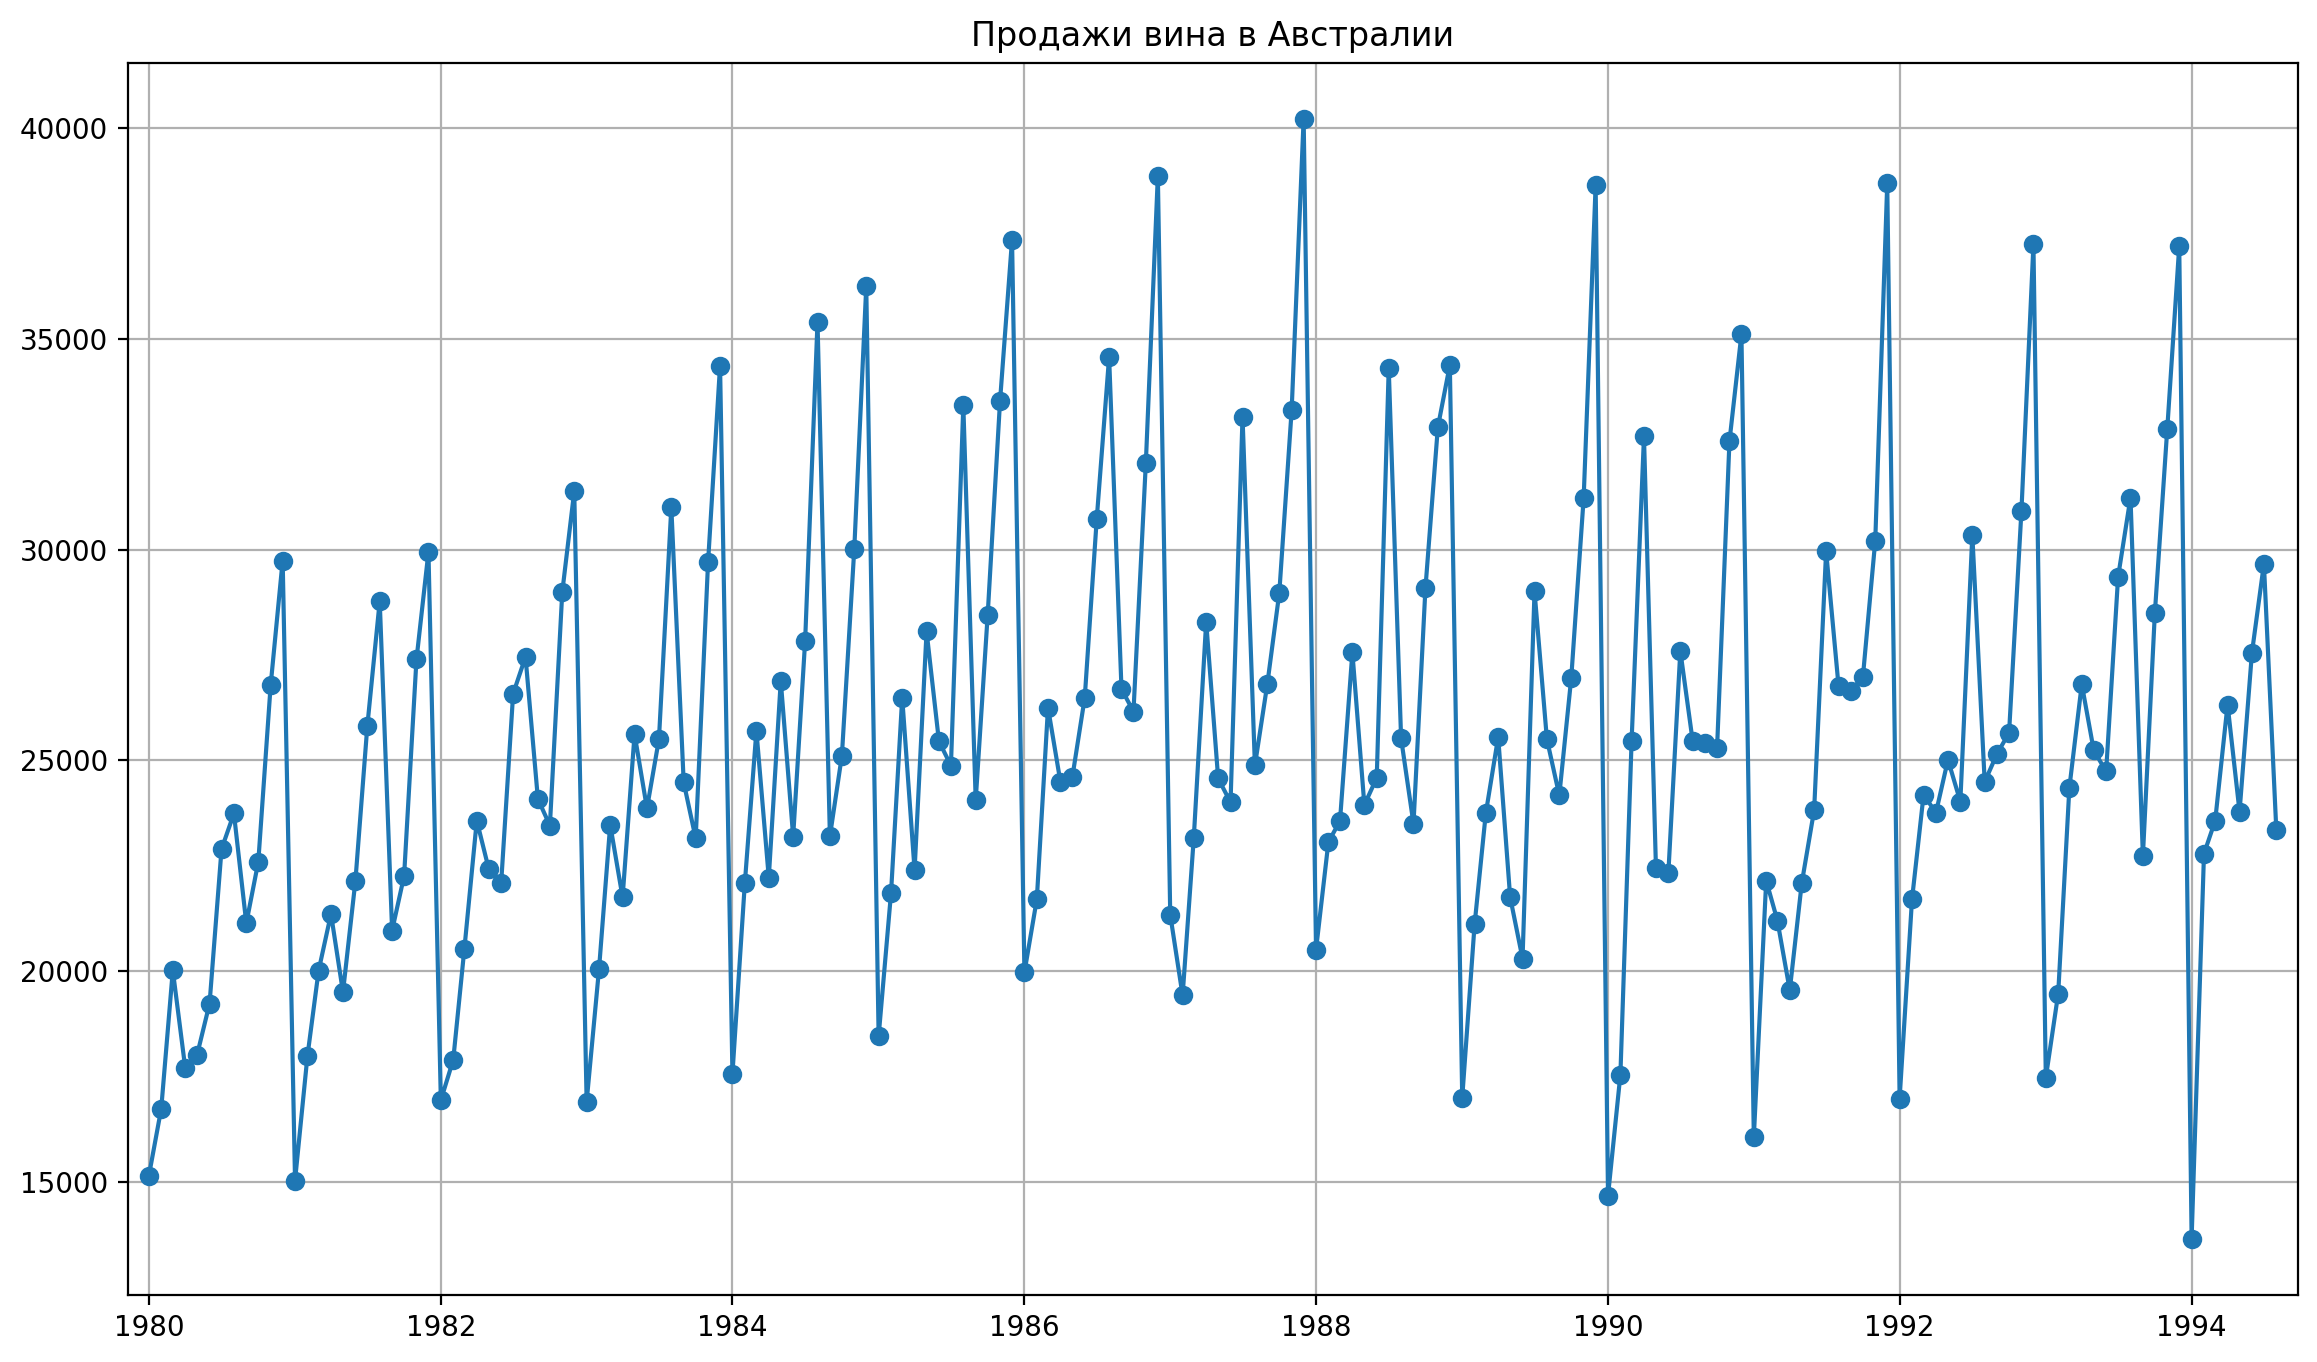

In [83]:
# визуализируем временной ряд

# задаем размер графика
fig, ax = plt.subplots(figsize=(14, 8))
# строим график
ax.plot(wine_data['sales'],
        marker='o')
# задаем заголовок графика
ax.set_title("Продажи вина в Австралии")
# задаем начало оси x с отступом
ax.margins(x=0.01)
# задаем координатную сетку
ax.grid();

-------------------------------------
TRAIN: ['1980-01-01', '1993-02-01'] TEST: ['1993-03-01', '1993-08-01']

Общее кол-во наблюдений: 164
Обучающий набор: 158
Тестовый набор: 6

Защита:

month
1980-01-01   15136.00000
1980-02-01   16733.00000
1980-03-01   20016.00000
1980-04-01   17708.00000
1980-05-01   18019.00000
                 ...    
1993-04-01           NaN
1993-05-01           NaN
1993-06-01           NaN
1993-07-01           NaN
1993-08-01           NaN
Name: sales, Length: 164, dtype: float64

Доб. признаки:
                 Lag_6       Lag_8      Lag_10  Moving_mean_6  Moving_mean_8
month                                                                       
1980-01-01         NaN         NaN         NaN            NaN            NaN
1980-02-01         NaN         NaN         NaN    15136.00000    15136.00000
1980-03-01         NaN         NaN         NaN    15934.50000    15934.50000
1980-04-01         NaN         NaN         NaN    17295.00000    17295.00000
1980-05-01  

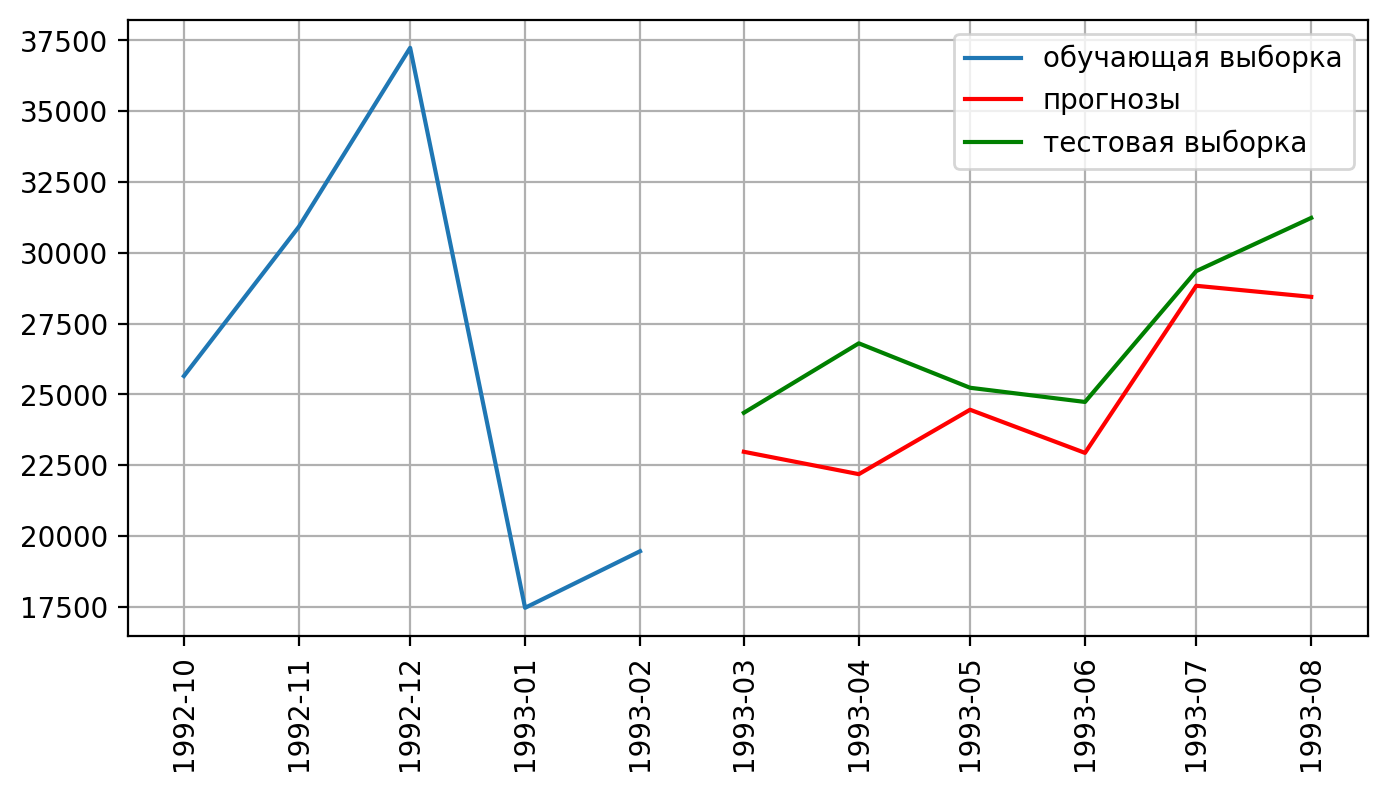

-------------------------------------
TRAIN: ['1980-01-01', '1993-08-01'] TEST: ['1993-09-01', '1994-02-01']

Общее кол-во наблюдений: 170
Обучающий набор: 164
Тестовый набор: 6

Защита:

month
1980-01-01   15136.00000
1980-02-01   16733.00000
1980-03-01   20016.00000
1980-04-01   17708.00000
1980-05-01   18019.00000
                 ...    
1993-10-01           NaN
1993-11-01           NaN
1993-12-01           NaN
1994-01-01           NaN
1994-02-01           NaN
Name: sales, Length: 170, dtype: float64

Доб. признаки:
                 Lag_6       Lag_8      Lag_10  Moving_mean_6  Moving_mean_8
month                                                                       
1980-01-01         NaN         NaN         NaN            NaN            NaN
1980-02-01         NaN         NaN         NaN    15136.00000    15136.00000
1980-03-01         NaN         NaN         NaN    15934.50000    15934.50000
1980-04-01         NaN         NaN         NaN    17295.00000    17295.00000
1980-05-01  

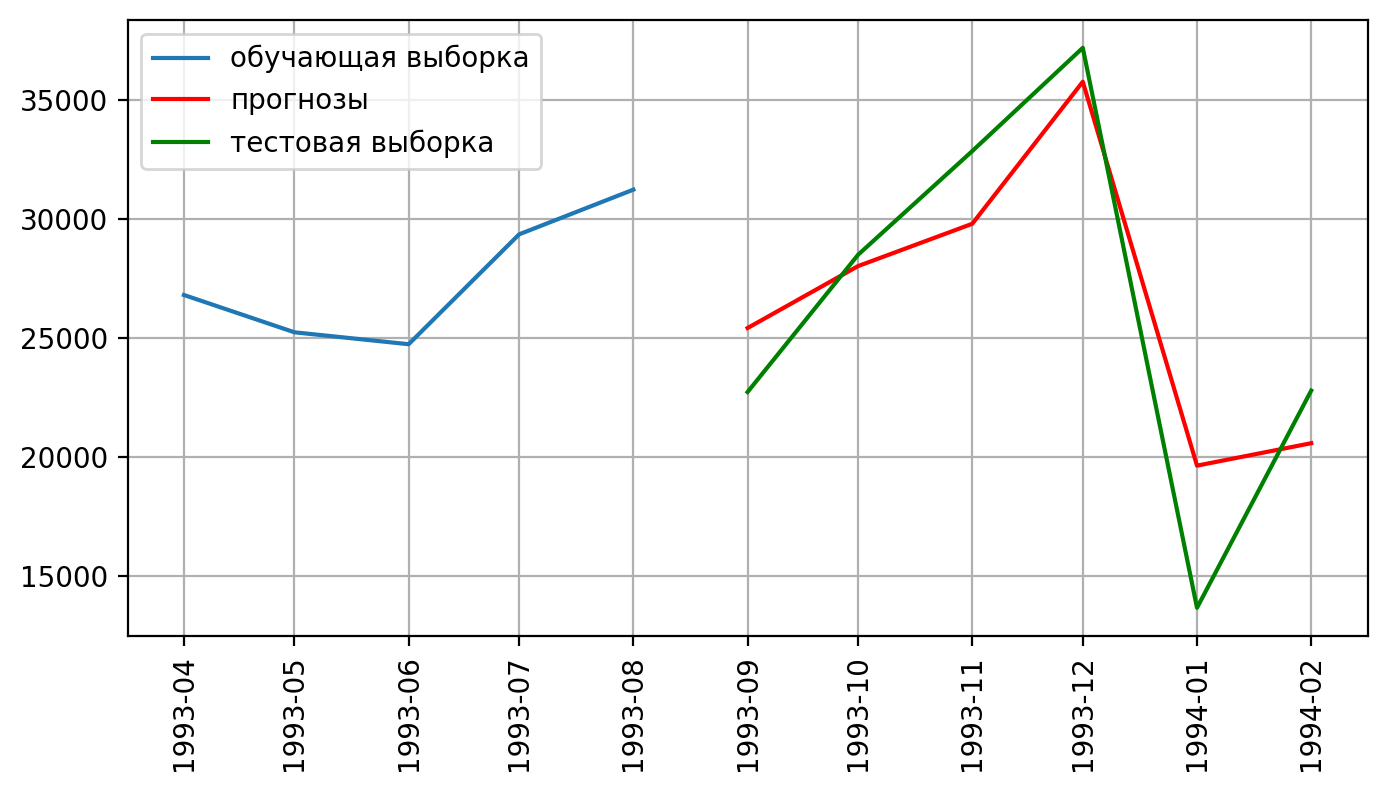

-------------------------------------
TRAIN: ['1980-01-01', '1994-02-01'] TEST: ['1994-03-01', '1994-08-01']

Общее кол-во наблюдений: 176
Обучающий набор: 170
Тестовый набор: 6

Защита:

month
1980-01-01   15136.00000
1980-02-01   16733.00000
1980-03-01   20016.00000
1980-04-01   17708.00000
1980-05-01   18019.00000
                 ...    
1994-04-01           NaN
1994-05-01           NaN
1994-06-01           NaN
1994-07-01           NaN
1994-08-01           NaN
Name: sales, Length: 176, dtype: float64

Доб. признаки:
                 Lag_6       Lag_8      Lag_10  Moving_mean_6  Moving_mean_8
month                                                                       
1980-01-01         NaN         NaN         NaN            NaN            NaN
1980-02-01         NaN         NaN         NaN    15136.00000    15136.00000
1980-03-01         NaN         NaN         NaN    15934.50000    15934.50000
1980-04-01         NaN         NaN         NaN    17295.00000    17295.00000
1980-05-01  

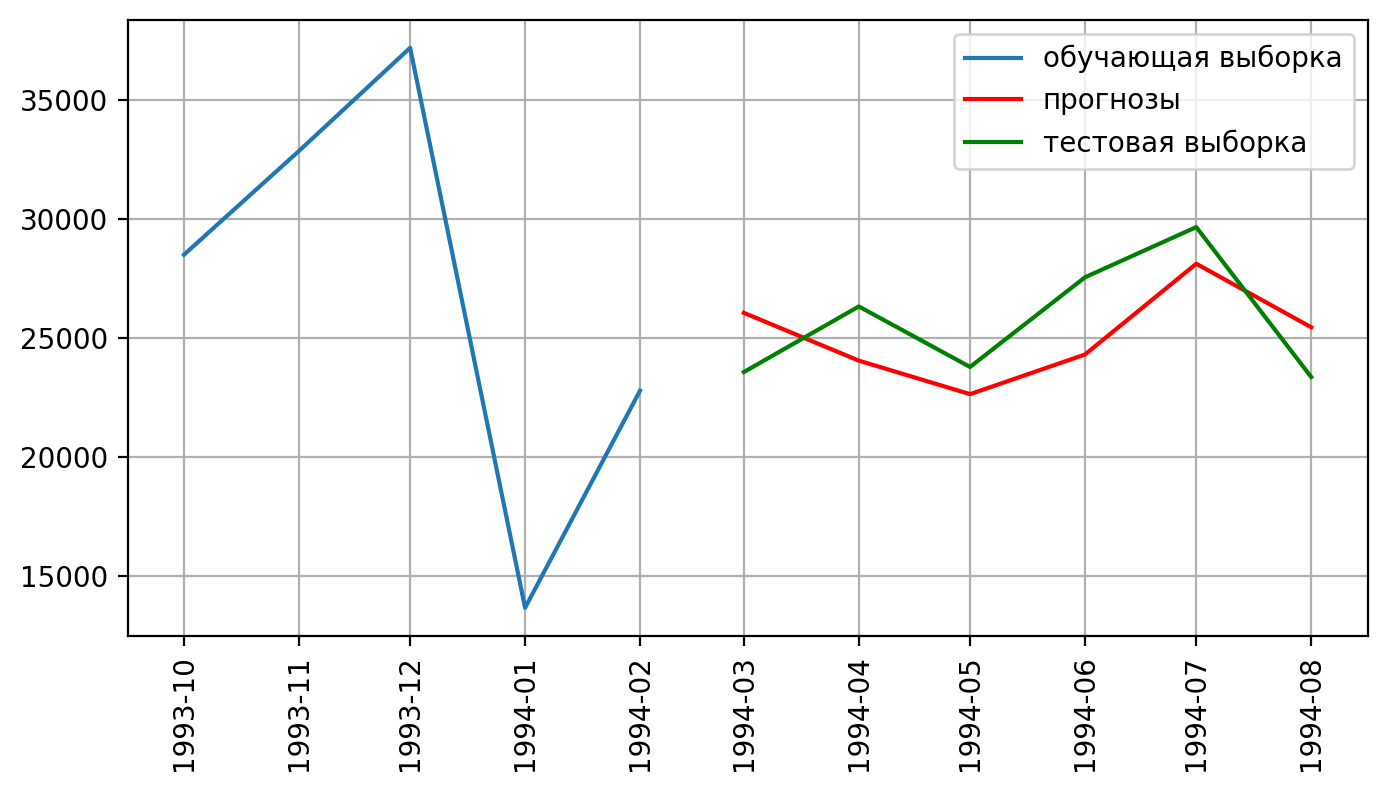

Среднее значение RMSE=2601.096

Список признаков:
['Lag_10', 'Lag_6', 'Lag_8', 'Moving_mean_6', 'Moving_mean_8']


In [84]:
# создаем массив меток и массив признаков
y_wine_data = wine_data.pop('sales')

# создаем модель CatBoost
ctbst_model = CatBoostRegressor(
    random_seed=42, 
    n_estimators=600,
    learning_rate=0.05,
    loss_function='MAE',
    depth=9,
    logging_level='Silent')

# применяем функцию перекрестной проверки расширяющимся
# окном с формированием скользящих статистик и лагов
# на каждой итерации
timeseries_cv_with_lags_and_moving_stats(
    wine_data, y_wine_data, model=ctbst_model,
    lags_range=list(range(6, 11, 2)),  
    moving_stats_range=[6, 8],
    print_features=True,
    aggfunc='mean', test_size=6, n_splits=3)

## 4. Взвешенные скользящие статистики

In [85]:
# загружаем данные
data = load_data()
# задаем массив весов длиной с ширину окна
weights = np.array([0.7, 0.8, 0.9, 1])
# вычисляем взвешенные скользящие средние c шириной окна 4,
# в знаменателе - количество наблюдений в окне
data['weighted_rolling_mean4'] = data['sales'].rolling(
    window=4).apply(lambda x: np.mean(weights * x))
data

,sales,weighted_rolling_mean4
2018-01-09,2400,NaN
2018-01-10,2800,NaN
2018-01-11,2500,NaN
2018-01-12,2890,2265.00000
2018-01-13,2610,2292.75000
2018-01-14,2500,2227.75000
2018-01-15,2750,2277.75000
2018-01-16,2700,2250.50000
2018-01-17,2250,2157.50000
2018-01-18,2350,2115.00000


In [86]:
# вручную вычисляем взвешенные скользящие средние 
# c шириной окна 4, в знаменателе - количество 
# наблюдений в окне
data['weighted_rolling_mean4_manually'] = np.NaN
data.iloc[3, 2] = (2400 * 0.7 + 2800 * 0.8 + 
                   2500 * 0.9 + 2890 * 1) / 4
data.iloc[4, 2] = (2800 * 0.7 + 2500 * 0.8 + 
                   2890 * 0.9 + 2610 * 1) / 4
data.iloc[5, 2] = (2500 * 0.7 + 2890 * 0.8 + 
                   2610 * 0.9 + 2500 * 1) / 4
data.iloc[6, 2] = (2890 * 0.7 + 2610 * 0.8 + 
                   2500 * 0.9 + 2750 * 1) / 4
data.iloc[7, 2] = (2610 * 0.7 + 2500 * 0.8 + 
                   2750 * 0.9 + 2700 * 1) / 4
data.iloc[8, 2] = (2500 * 0.7 + 2750 * 0.8 + 
                   2700 * 0.9 + 2250 * 1) / 4
data.iloc[9, 2] = (2750 * 0.7 + 2700 * 0.8 + 
                   2250 * 0.9 + 2350 * 1) / 4
data.iloc[10, 2] = (2700 * 0.7 + 2250 * 0.8 + 
                    2350 * 0.9 + 2550 * 1) / 4
data.iloc[11, 2] = (2250 * 0.7 + 2350 * 0.8 + 
                    2550 * 0.9 + 3000 * 1) / 4
data

,sales,weighted_rolling_mean4,weighted_rolling_mean4_manually
2018-01-09,2400,NaN,NaN
2018-01-10,2800,NaN,NaN
2018-01-11,2500,NaN,NaN
2018-01-12,2890,2265.00000,2265.00000
2018-01-13,2610,2292.75000,2292.75000
2018-01-14,2500,2227.75000,2227.75000
2018-01-15,2750,2277.75000,2277.75000
2018-01-16,2700,2250.50000,2250.50000
2018-01-17,2250,2157.50000,2157.50000
2018-01-18,2350,2115.00000,2115.00000


In [87]:
# вычисляем взвешенные скользящие средние c шириной окна 4,
# в знаменателе - сумма весов наблюдений в окне
data['weighted_rolling_mean4_oth'] = data['sales'].rolling(
    window=4).apply(lambda x: np.sum(weights * x) / 
                    np.sum(weights))
data

,sales,weighted_rolling_mean4,weighted_rolling_mean4_manually,weighted_rolling_mean4_oth
2018-01-09,2400,NaN,NaN,NaN
2018-01-10,2800,NaN,NaN,NaN
2018-01-11,2500,NaN,NaN,NaN
2018-01-12,2890,2265.00000,2265.00000,2664.70588
2018-01-13,2610,2292.75000,2292.75000,2697.35294
2018-01-14,2500,2227.75000,2227.75000,2620.88235
2018-01-15,2750,2277.75000,2277.75000,2679.70588
2018-01-16,2700,2250.50000,2250.50000,2647.64706
2018-01-17,2250,2157.50000,2157.50000,2538.23529
2018-01-18,2350,2115.00000,2115.00000,2488.23529


In [88]:
# вручную вычисляем взвешенные скользящие средние 
# c шириной окна 4, в знаменателе - сумма весов 
# наблюдений в окне
data['weighted_rolling_mean4_oth_manually'] = np.NaN
sum_of_weights = (0.7 + 0.8 + 0.9 + 1)
data.iloc[3, 4] = (2400 * 0.7 + 2800 * 0.8 + 
                   2500 * 0.9 + 2890 * 1) / sum_of_weights
data.iloc[4, 4] = (2800 * 0.7 + 2500 * 0.8 + 
                   2890 * 0.9 + 2610 * 1) / sum_of_weights
data.iloc[5, 4] = (2500 * 0.7 + 2890 * 0.8 + 
                   2610 * 0.9 + 2500 * 1) / sum_of_weights
data.iloc[6, 4] = (2890 * 0.7 + 2610 * 0.8 + 
                   2500 * 0.9 + 2750 * 1) / sum_of_weights
data.iloc[7, 4] = (2610 * 0.7 + 2500 * 0.8 + 
                   2750 * 0.9 + 2700 * 1) / sum_of_weights
data.iloc[8, 4] = (2500 * 0.7 + 2750 * 0.8 + 
                   2700 * 0.9 + 2250 * 1) / sum_of_weights
data.iloc[9, 4] = (2750 * 0.7 + 2700 * 0.8 + 
                   2250 * 0.9 + 2350 * 1) / sum_of_weights
data.iloc[10, 4] = (2700 * 0.7 + 2250 * 0.8 + 
                    2350 * 0.9 + 2550 * 1) / sum_of_weights
data.iloc[11, 4] = (2250 * 0.7 + 2350 * 0.8 + 
                    2550 * 0.9 + 3000 * 1) / sum_of_weights
data

,sales,weighted_rolling_mean4,weighted_rolling_mean4_manually,weighted_rolling_mean4_oth,weighted_rolling_mean4_oth_manually
2018-01-09,2400,NaN,NaN,NaN,NaN
2018-01-10,2800,NaN,NaN,NaN,NaN
2018-01-11,2500,NaN,NaN,NaN,NaN
2018-01-12,2890,2265.00000,2265.00000,2664.70588,2664.70588
2018-01-13,2610,2292.75000,2292.75000,2697.35294,2697.35294
2018-01-14,2500,2227.75000,2227.75000,2620.88235,2620.88235
2018-01-15,2750,2277.75000,2277.75000,2679.70588,2679.70588
2018-01-16,2700,2250.50000,2250.50000,2647.64706,2647.64706
2018-01-17,2250,2157.50000,2157.50000,2538.23529,2538.23529
2018-01-18,2350,2115.00000,2115.00000,2488.23529,2488.23529


In [89]:
# отключаем предупреждения
import warnings
warnings.filterwarnings('ignore')

In [90]:
# значения в наблюдениях, которые будут приходиться 
# на тест (последние 4 наблюдения) заменяем 
# на значения NaN
HORIZON = 4
data['sales'].iloc[-HORIZON:] = np.NaN

# вычисляем взвешенное скользящее среднее c шириной 
# окна 4 и лагом 4, в знаменателе - количество 
# наблюдений в окне
data['weighted_rolling_mean4_sh'] = data['sales'].shift(
    periods=4).rolling(window=4, min_periods=1).apply(
    lambda x: np.nanmean(weights * x))

# вычисляем взвешенное скользящее среднее c шириной 
# окна 4 и лагом 4, в знаменателе - сумма весов 
# наблюдений в окне
data['weighted_rolling_mean4_oth_sh'] = data['sales'].shift(
    periods=4).rolling(window=4, min_periods=1).apply(
    lambda x: np.sum(weights * x) / np.sum(weights))
data

,sales,weighted_rolling_mean4,weighted_rolling_mean4_manually,weighted_rolling_mean4_oth,weighted_rolling_mean4_oth_manually,weighted_rolling_mean4_sh,weighted_rolling_mean4_oth_sh
2018-01-09,2400.00000,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-10,2800.00000,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-11,2500.00000,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-12,2890.00000,2265.00000,2265.00000,2664.70588,2664.70588,NaN,NaN
2018-01-13,2610.00000,2292.75000,2292.75000,2697.35294,2697.35294,2400.00000,705.88235
2018-01-14,2500.00000,2227.75000,2227.75000,2620.88235,2620.88235,2480.00000,1458.82353
2018-01-15,2750.00000,2277.75000,2277.75000,2679.70588,2679.70588,2313.33333,2041.17647
2018-01-16,2700.00000,2250.50000,2250.50000,2647.64706,2647.64706,2265.00000,2664.70588
2018-01-17,NaN,2157.50000,2157.50000,2538.23529,2538.23529,2292.75000,2697.35294
2018-01-18,NaN,2115.00000,2115.00000,2488.23529,2488.23529,2227.75000,2620.88235


## 5. Групповые скользящие статистики

In [91]:
# загружаем данные
data = load_data()
# создаем столбец Class с двумя категориями
data['class'] = pd.Series(['A', 'B', 'A', 'B', 'A', 'B', 
                           'B', 'B', 'B', 'B', 'A', 'B'],
                          index=data.index)
data

,sales,class
2018-01-09,2400,A
2018-01-10,2800,B
2018-01-11,2500,A
2018-01-12,2890,B
2018-01-13,2610,A
2018-01-14,2500,B
2018-01-15,2750,B
2018-01-16,2700,B
2018-01-17,2250,B
2018-01-18,2350,B


In [92]:
# отсортируем по переменной Class
data = data.sort_values('class', ascending=True)
data

,sales,class
2018-01-09,2400,A
2018-01-11,2500,A
2018-01-13,2610,A
2018-01-19,2550,A
2018-01-10,2800,B
2018-01-12,2890,B
2018-01-14,2500,B
2018-01-15,2750,B
2018-01-16,2700,B
2018-01-17,2250,B


In [93]:
# вычислим групповые скользящие средние
# с шириной окна 4 и лагом 1
data['groupby_rolling_mean'] = data.groupby(
    'class')['sales'].transform(lambda s: s.shift(
    periods=1).rolling(window=4, min_periods=1).agg('mean'))
data

,sales,class,groupby_rolling_mean
2018-01-09,2400,A,NaN
2018-01-11,2500,A,2400.00000
2018-01-13,2610,A,2450.00000
2018-01-19,2550,A,2503.33333
2018-01-10,2800,B,NaN
2018-01-12,2890,B,2800.00000
2018-01-14,2500,B,2845.00000
2018-01-15,2750,B,2730.00000
2018-01-16,2700,B,2735.00000
2018-01-17,2250,B,2710.00000


In [94]:
# создаем набор новых данных
new_data = pd.DataFrame(
    {'sales': [np.NaN, np.NaN, np.NaN, np.NaN],
     'class': ['A', 'A', 'A', 'B']}, 
    index=pd.date_range(start='2018-01-21', periods=4))
new_data

,sales,class
2018-01-21,NaN,A
2018-01-22,NaN,A
2018-01-23,NaN,A
2018-01-24,NaN,B


In [95]:
# вручную вычислим групповые скользящие 
# средние в наборе новых данных
new_data['groupby_rolling_mean'] = np.NaN
new_data.iloc[0, 2] = (2550 + 2610 + 2500 + 2400) / 4
new_data.iloc[1, 2] = (2550 + 2610 + 2500) / 3
new_data.iloc[2, 2] = (2550 + 2610) / 2
new_data.iloc[3, 2] = (3000 + 2350 + 2250 + 2700) / 4
new_data

,sales,class,groupby_rolling_mean
2018-01-21,NaN,A,2515.00000
2018-01-22,NaN,A,2553.33333
2018-01-23,NaN,A,2580.00000
2018-01-24,NaN,B,2575.00000


In [96]:
# конкатенируем исторический набор и набор новых данных
df = pd.concat([data, new_data], axis=0)
# удалим переменную groupby_rolling_mean
df.drop('groupby_rolling_mean', axis=1, inplace=True)
df

,sales,class
2018-01-09,2400.00000,A
2018-01-11,2500.00000,A
2018-01-13,2610.00000,A
2018-01-19,2550.00000,A
2018-01-10,2800.00000,B
2018-01-12,2890.00000,B
2018-01-14,2500.00000,B
2018-01-15,2750.00000,B
2018-01-16,2700.00000,B
2018-01-17,2250.00000,B


In [97]:
# функция для создания групповых скользящих статистик
def groupby_moving_stats(df, by, target, min_periods=1, 
                         window=4, aggfunc='mean', 
                         offset=False, start_date=None): 
    """
    Создает групповые скользящие статистики.
    
    Параметры
    ----------
    df: pandas.DataFrame
        Датафрейм Pandas, наблюдения, приходящиеся 
        на историческую (обучающую) часть, должны 
        быть отсортированы по категориям
        группирующей переменной.
    by: string
        Имя группирующего столбца.
    target: string
        Имя агрегируемого столбца.
    min_periods: int, по умолчанию 1    
        Минимальное количество наблюдений в окне для
        вычисления скользящих статистик.
    window: int, по умолчанию 4
        Ширина окна.
    aggfunc: string, по умолчанию 'mean'
        Агрегирующая функция.    
    offset: bool, по умолчанию True
        Вычисляет групповые скользящие 
        статистики со смещением по времени.
    start_date: datetime
        Стартовая дата для смещения.  
    """ 
    if offset:
        df = df[df.index >= start_date]

    # если не является списком
    if type(by) != list:
        # превращаем в список
        by = [by]
        
    df = df.groupby(by)[target].transform(
        lambda x: x.shift(1).rolling(
            window=window, 
            min_periods=min_periods).agg(aggfunc))
    
    df.fillna(0, inplace=True)
    return df

In [98]:
# создаем список агрегирующих функций
aggfunc_lst = ['mean', 'median', 'sum']

# вычисляем групповые скользящие статистики с 
# помощью функции groupby_moving_stats()
for aggfunc in aggfunc_lst:
    df[f"groupby_rolling_{aggfunc}"] = groupby_moving_stats(
    df, by='class', target='sales',
    min_periods=1, window=4, aggfunc=aggfunc)
df

,sales,class,groupby_rolling_mean,groupby_rolling_median,groupby_rolling_sum
2018-01-09,2400.00000,A,0.00000,0.00000,0.00000
2018-01-11,2500.00000,A,2400.00000,2400.00000,2400.00000
2018-01-13,2610.00000,A,2450.00000,2450.00000,4900.00000
2018-01-19,2550.00000,A,2503.33333,2500.00000,7510.00000
2018-01-10,2800.00000,B,0.00000,0.00000,0.00000
2018-01-12,2890.00000,B,2800.00000,2800.00000,2800.00000
2018-01-14,2500.00000,B,2845.00000,2845.00000,5690.00000
2018-01-15,2750.00000,B,2730.00000,2800.00000,8190.00000
2018-01-16,2700.00000,B,2735.00000,2775.00000,10940.00000
2018-01-17,2250.00000,B,2710.00000,2725.00000,10840.00000


## 6. Расширяющиеся статистики

In [99]:
# загружаем данные
data = load_data()

# создаем расширяющееся среднее
data['expanding_mean'] = data['sales'].expanding().mean()
data

,sales,expanding_mean
2018-01-09,2400,2400.00000
2018-01-10,2800,2600.00000
2018-01-11,2500,2566.66667
2018-01-12,2890,2647.50000
2018-01-13,2610,2640.00000
2018-01-14,2500,2616.66667
2018-01-15,2750,2635.71429
2018-01-16,2700,2643.75000
2018-01-17,2250,2600.00000
2018-01-18,2350,2575.00000


In [100]:
# удаляем переменную expanding_mean
data.drop('expanding_mean', axis=1, inplace=True)
# в последних 4 наблюдениях, которые будут соответствовать
# тестовой выборке, значения переменной sales заменяем 
# на значения NaN
data.iloc[-4:] = np.NaN
data

,sales
2018-01-09,2400.00000
2018-01-10,2800.00000
2018-01-11,2500.00000
2018-01-12,2890.00000
2018-01-13,2610.00000
2018-01-14,2500.00000
2018-01-15,2750.00000
2018-01-16,2700.00000
2018-01-17,NaN
2018-01-18,NaN


In [101]:
# функция для создания расширяющихся статистик
def expanding_stats(series, min_periods=1, 
                    periods=1, aggfunc='mean'): 
    """
    Создает скользящие статистики.
    
    Параметры
    ----------
    min_periods: int, по умолчанию 1
        Минимальное количество наблюдений 
        в окне для вычисления 
        расширяющихся статистик.
    periods: int, по умолчанию 1
        Порядок лага, с которым вычисляем 
        расширяющиеся статистики (не должен 
        быть меньше горизонта 
        прогнозирования).
    aggfunc: string, по умолчанию 'mean'
        Агрегирующая функция.      
    """
    # вычисление расширяющихся статистик
    features = series.shift(
        periods=periods).expanding(
        min_periods=min_periods).agg(aggfunc)
    features.fillna(0, inplace=True)
    return features

In [102]:
# вычисляем расширяющиеся средние с лагом 4, т.е.
# с лагом, равном горизонту прогнозирования
data['expanding_mean'] = expanding_stats(
    data['sales'],
    periods=4,
    min_periods=1, 
    aggfunc='mean')
data

,sales,expanding_mean
2018-01-09,2400.00000,0.00000
2018-01-10,2800.00000,0.00000
2018-01-11,2500.00000,0.00000
2018-01-12,2890.00000,0.00000
2018-01-13,2610.00000,2400.00000
2018-01-14,2500.00000,2600.00000
2018-01-15,2750.00000,2566.66667
2018-01-16,2700.00000,2647.50000
2018-01-17,NaN,2640.00000
2018-01-18,NaN,2616.66667


## 7. Групповые статистики

In [103]:
# загружаем данные
data = load_data()

# создаем столбец Class с тремя категориями
data['class'] = pd.Series(
    ['A', 'B', 'A', 'B', 'A', 'B', 
     'B', 'B', 'B', 'B', 'A', 'C'],
    index=data.index)
# создаем количественный столбец income
data['income'] = pd.Series(
    [4500, 5000, 5100, 4800, 5300, 5200, 
     4800, 4950, 5050, 4850, 4700, 5030],
    index=data.index)
# разбиваем набор на обучающую и тестовую выборки
train, test = data[0:len(data)-4], data[len(data)-4:]

In [104]:
# смотрим обучающую выборку
train

,sales,class,income
2018-01-09,2400,A,4500
2018-01-10,2800,B,5000
2018-01-11,2500,A,5100
2018-01-12,2890,B,4800
2018-01-13,2610,A,5300
2018-01-14,2500,B,5200
2018-01-15,2750,B,4800
2018-01-16,2700,B,4950


In [105]:
# смотрим тестовую выборку
test

,sales,class,income
2018-01-17,2250,B,5050
2018-01-18,2350,B,4850
2018-01-19,2550,A,4700
2018-01-20,3000,C,5030


In [106]:
# пишем функцию вычисления групповых статистик
def grouped_stats(df_treat, df_calc, var, 
                  by, func='mean', fillna=None):
    """
    Создает групповые статистики.
    
    Параметры
    ----------
    df_treat: pandas.DataFrame
        Датафрейм Pandas, для которого 
        вычисляем статистики.
    df_calc: pandas.DataFrame
        Датафрейм Pandas, на основе которого 
        вычисляются статистики.
    var: string
        Имя агрегируемого столбца.
    by: string
        Имя группирующего столбца.
    aggfunc: string, по умолчанию 'mean'
        Агрегирующая функция.  
    fillna, int, по умолчанию -1
        Стратегия импутации пропусков.
    """
    # если не является списком
    if type(by) != list:
        # превращаем в список
        by = [by]
    # задаем имя
    name = '{0}_by_{1}_mean'.format(var, by)
    # получаем статистики по каждой комбинации
    # категорий признаков в списке
    grp = df_calc.groupby(by)[[var]].agg(func)
    # присваиваем имя
    grp.columns = [name]
    # записываем результаты в исходный датафрейм
    var = pd.merge(df_treat[by], grp, left_on=by, 
                   right_index=True, how='left')[name]
    
    # импутируем пропуски
    if fillna is not None:
        var.fillna(fillna, inplace=True)
        
    return var

In [107]:
# вычисляем групповые средние, минимумы, максимумы, 
# медианы, стандартные отклонения, разности, средние 
# абсолютные отклонения, медианные абсолютные 
# отклонения на обучающей выборке
train['mean_inc_by_class'] = grouped_stats(
    train, train, var='income', by='class', 
    func='mean', fillna=train['income'].mean())
train['min_inc_by_class'] = grouped_stats(
    train, train, var='income', by='class', 
    func='min', fillna=train['income'].mean())
train['max_inc_by_class'] = grouped_stats(
    train, train, var='income', by='class', 
    func='max', fillna=train['income'].mean())
train['median_inc_by_class'] = grouped_stats(
    train, train, var='income', by='class', 
    func='median', fillna=train['income'].mean())
train['std_inc_by_class'] = grouped_stats(
    train, train, var='income', by='class', 
    func='std', fillna=train['income'].mean())
train['diff_inc_by_class'] = grouped_stats(
    train, train, var='income', by='class', 
    func=np.ptp, fillna=train['income'].mean())
train['mad_inc_by_class'] = grouped_stats(
    train, train, var='income', by='class', 
    func='mad', fillna=train['income'].mean())
train['mdad_inc_by_class'] = grouped_stats(
    train, train, var='income', by='class', 
    func=lambda x: np.nanmedian(
        np.abs(x - np.nanmedian(x, axis=0)), axis=0), 
    fillna=train['income'].mean())
train

,sales,class,income,mean_inc_by_class,min_inc_by_class,max_inc_by_class,median_inc_by_class,std_inc_by_class,diff_inc_by_class,mad_inc_by_class,mdad_inc_by_class
2018-01-09,2400,A,4500,4966.66667,4500,5300,5100.00000,416.33320,800,311.11111,200.00000
2018-01-10,2800,B,5000,4950.00000,4800,5200,4950.00000,165.83124,400,120.00000,150.00000
2018-01-11,2500,A,5100,4966.66667,4500,5300,5100.00000,416.33320,800,311.11111,200.00000
2018-01-12,2890,B,4800,4950.00000,4800,5200,4950.00000,165.83124,400,120.00000,150.00000
2018-01-13,2610,A,5300,4966.66667,4500,5300,5100.00000,416.33320,800,311.11111,200.00000
2018-01-14,2500,B,5200,4950.00000,4800,5200,4950.00000,165.83124,400,120.00000,150.00000
2018-01-15,2750,B,4800,4950.00000,4800,5200,4950.00000,165.83124,400,120.00000,150.00000
2018-01-16,2700,B,4950,4950.00000,4800,5200,4950.00000,165.83124,400,120.00000,150.00000


In [108]:
# вычисляем групповые средние, минимумы, максимумы, 
# медианы, стандартные отклонения, разности, средние 
# абсолютные отклонения, медианные абсолютные 
# отклонения на тестовой выборке
test['mean_inc_by_class'] = grouped_stats(
    test, train, var='income', by='class', 
    func='mean', fillna=train['income'].mean())
test['min_inc_by_class'] = grouped_stats(
    test, train, var='income', by='class', 
    func='min', fillna=train['income'].mean())
test['max_inc_by_class'] = grouped_stats(
    test, train, var='income', by='class', 
    func='max', fillna=train['income'].mean())
test['median_inc_by_class'] = grouped_stats(
    test, train, var='income', by='class', 
    func='median', fillna=train['income'].mean())
test['std_inc_by_class'] = grouped_stats(
    test, train, var='income', by='class', 
    func='std', fillna=train['income'].mean())
test['diff_inc_by_class'] = grouped_stats(
    test, train, var='income', by='class', 
    func=np.ptp, fillna=train['income'].mean())
test['mad_inc_by_class'] = grouped_stats(
    test, train, var='income', by='class', 
    func='mad', fillna=train['income'].mean())
test['mdad_inc_by_class'] = grouped_stats(
    test, train, var='income', by='class', 
    func=lambda x: np.nanmedian(
        np.abs(x - np.nanmedian(x, axis=0)), axis=0), 
    fillna=train['income'].mean())
test

,sales,class,income,mean_inc_by_class,min_inc_by_class,max_inc_by_class,median_inc_by_class,std_inc_by_class,diff_inc_by_class,mad_inc_by_class,mdad_inc_by_class
2018-01-17,2250,B,5050,4950.00000,4800.00000,5200.00000,4950.00000,165.83124,400.00000,120.00000,150.00000
2018-01-18,2350,B,4850,4950.00000,4800.00000,5200.00000,4950.00000,165.83124,400.00000,120.00000,150.00000
2018-01-19,2550,A,4700,4966.66667,4500.00000,5300.00000,5100.00000,416.33320,800.00000,311.11111,200.00000
2018-01-20,3000,C,5030,4956.25000,4956.25000,4956.25000,4956.25000,4956.25000,4956.25000,4956.25000,4956.25000
